In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
# define the train dataset
K = int(input())
theta_true = np.ones((K,1))
N = 200
a = 0
b = 1
X_arr = np.reshape(np.linspace(a, b, N),(N,1))
print(X_arr.shape)

(200, 1)


In [3]:
def vand(x, k):
    vand = np.ones((len(x),k))
    for i in range(k):
        vand[:,i:i+1] = x**i
    return vand
sigma_2 = 0.1
e = np.random.normal(0, sigma_2, (N,1))
Y = vand(X_arr, K) @ theta_true + e
print("Phi shape: ",vand(X_arr, K).shape)
print("Y shape: ",Y.shape)

Phi shape:  (200, 10)
Y shape:  (200, 1)


In [4]:
def f(X, Y, theta,lmbda, sigma_2=sigma_2):
    k = theta.shape[0]
    p = vand(X,k)
    square_error = np.linalg.norm(p @ theta - Y,2)**2
    return 1 / (2 * sigma_2) * square_error
def grad_f(X, Y, theta, lmbda, sigma_2=sigma_2):
    k = theta.shape[0]
    p = vand(X,k)
    error = p @ theta - Y
    return (1 / sigma_2) * p.T @ error

In [5]:
def NE(X,Y,k):
    X=vand(X,k)
    return np.linalg.inv(X.T@ X)@(X.T@Y)

In [6]:
def backtracking(f, grad_f, x,X_mat):
    alpha = 1
    c = 0.8
    tau = 0.25
    while f(x - alpha * grad_f(x,X_mat), X_mat) > f(x,X_mat) - c * alpha * np.linalg.norm(grad_f(x,X_mat), 2) ** 2:
        alpha = tau * alpha
        if alpha < 1e-3:
            break
    return alpha
def GD(grad_f, theta_zero, lmbda, D, kmax, tolf, tolx, alpha,sigma_2=sigma_2):
    k = theta_zero.shape[0]
    X, y = D
    theta = theta_zero
    theta_old = theta_zero
    i=0
    cond = True
    while i < kmax and cond :
        #alpha = backtracking(f, grad_f, xsol,X)
        theta = theta-alpha*grad_f(X,y,theta, lmbda)
        i+=1
        cond =  np.linalg.norm(grad_f(X,y,theta,lmbda)) > tolf*np.linalg.norm(grad_f(X,y,theta,lmbda)) and np.linalg.norm(theta-theta_old) > tolx
        theta_old = theta
    return theta

In [7]:
def SGD(grad_f, w0, lmbda, D, batch_size, n_epochs, learning_rate,sigma_2=sigma_2):
    K_d = w0.shape[0]
    # Initialize w
    w = w0 # (K,1)
    # Extract X and y
    X, y = D # X = (N,1)  y = (K,1)
    # Save in memory the length of X 
    N = X.shape[0] #
    # Compute the number of batches per epoch
    n_batch_per_epoch = N // batch_size 
    # Iterate over the epochs
    for epoch in range(n_epochs):
        idx = np.arange(N) # 1000
        np.random.shuffle(idx) 
        # Batch iteration
        for k in range(n_batch_per_epoch): 
            X_temp = X[idx[k * batch_size : (k+1) * batch_size]] # batch_sizex1
            y_temp = y[idx[k * batch_size : (k+1) * batch_size]] # batch_sizex1
            # Gradient descent update X, Y, k, theta, sigma_2
            w =  w - learning_rate * grad_f(X_temp, y_temp, w, lmbda,sigma_2)
            
    return w

In [8]:
def abs_avg_error(X_test, theta,y_true):
    k = theta.shape[0]
    N = X_test.shape[0]
    vandMatrix = vand(X_test,k)
    return (np.linalg.norm(vandMatrix@theta-y_true,2)**2)/N

In [9]:
def train_test_split(X, Y, N_train):
    N,d = X.shape
    idx = np.arange(0, N)
    np.random.shuffle(idx)
    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    X_train = X[train_idx,:]
    Y_train = Y[train_idx]
    X_test = X[test_idx,:]
    Y_test = Y[test_idx]
    return X_train,Y_train,X_test,Y_test
    
X_train,Y_train,X_test,Y_test = train_test_split(X_arr, Y, int(X_arr.shape[0]*0.7))
print("X_train=",X_train.shape,"Y_train=",Y_train.shape,"X_test=",X_test.shape,"Y_test=",Y_test.shape)

X_train= (140, 1) Y_train= (140, 1) X_test= (60, 1) Y_test= (60, 1)


### MLE with SGD

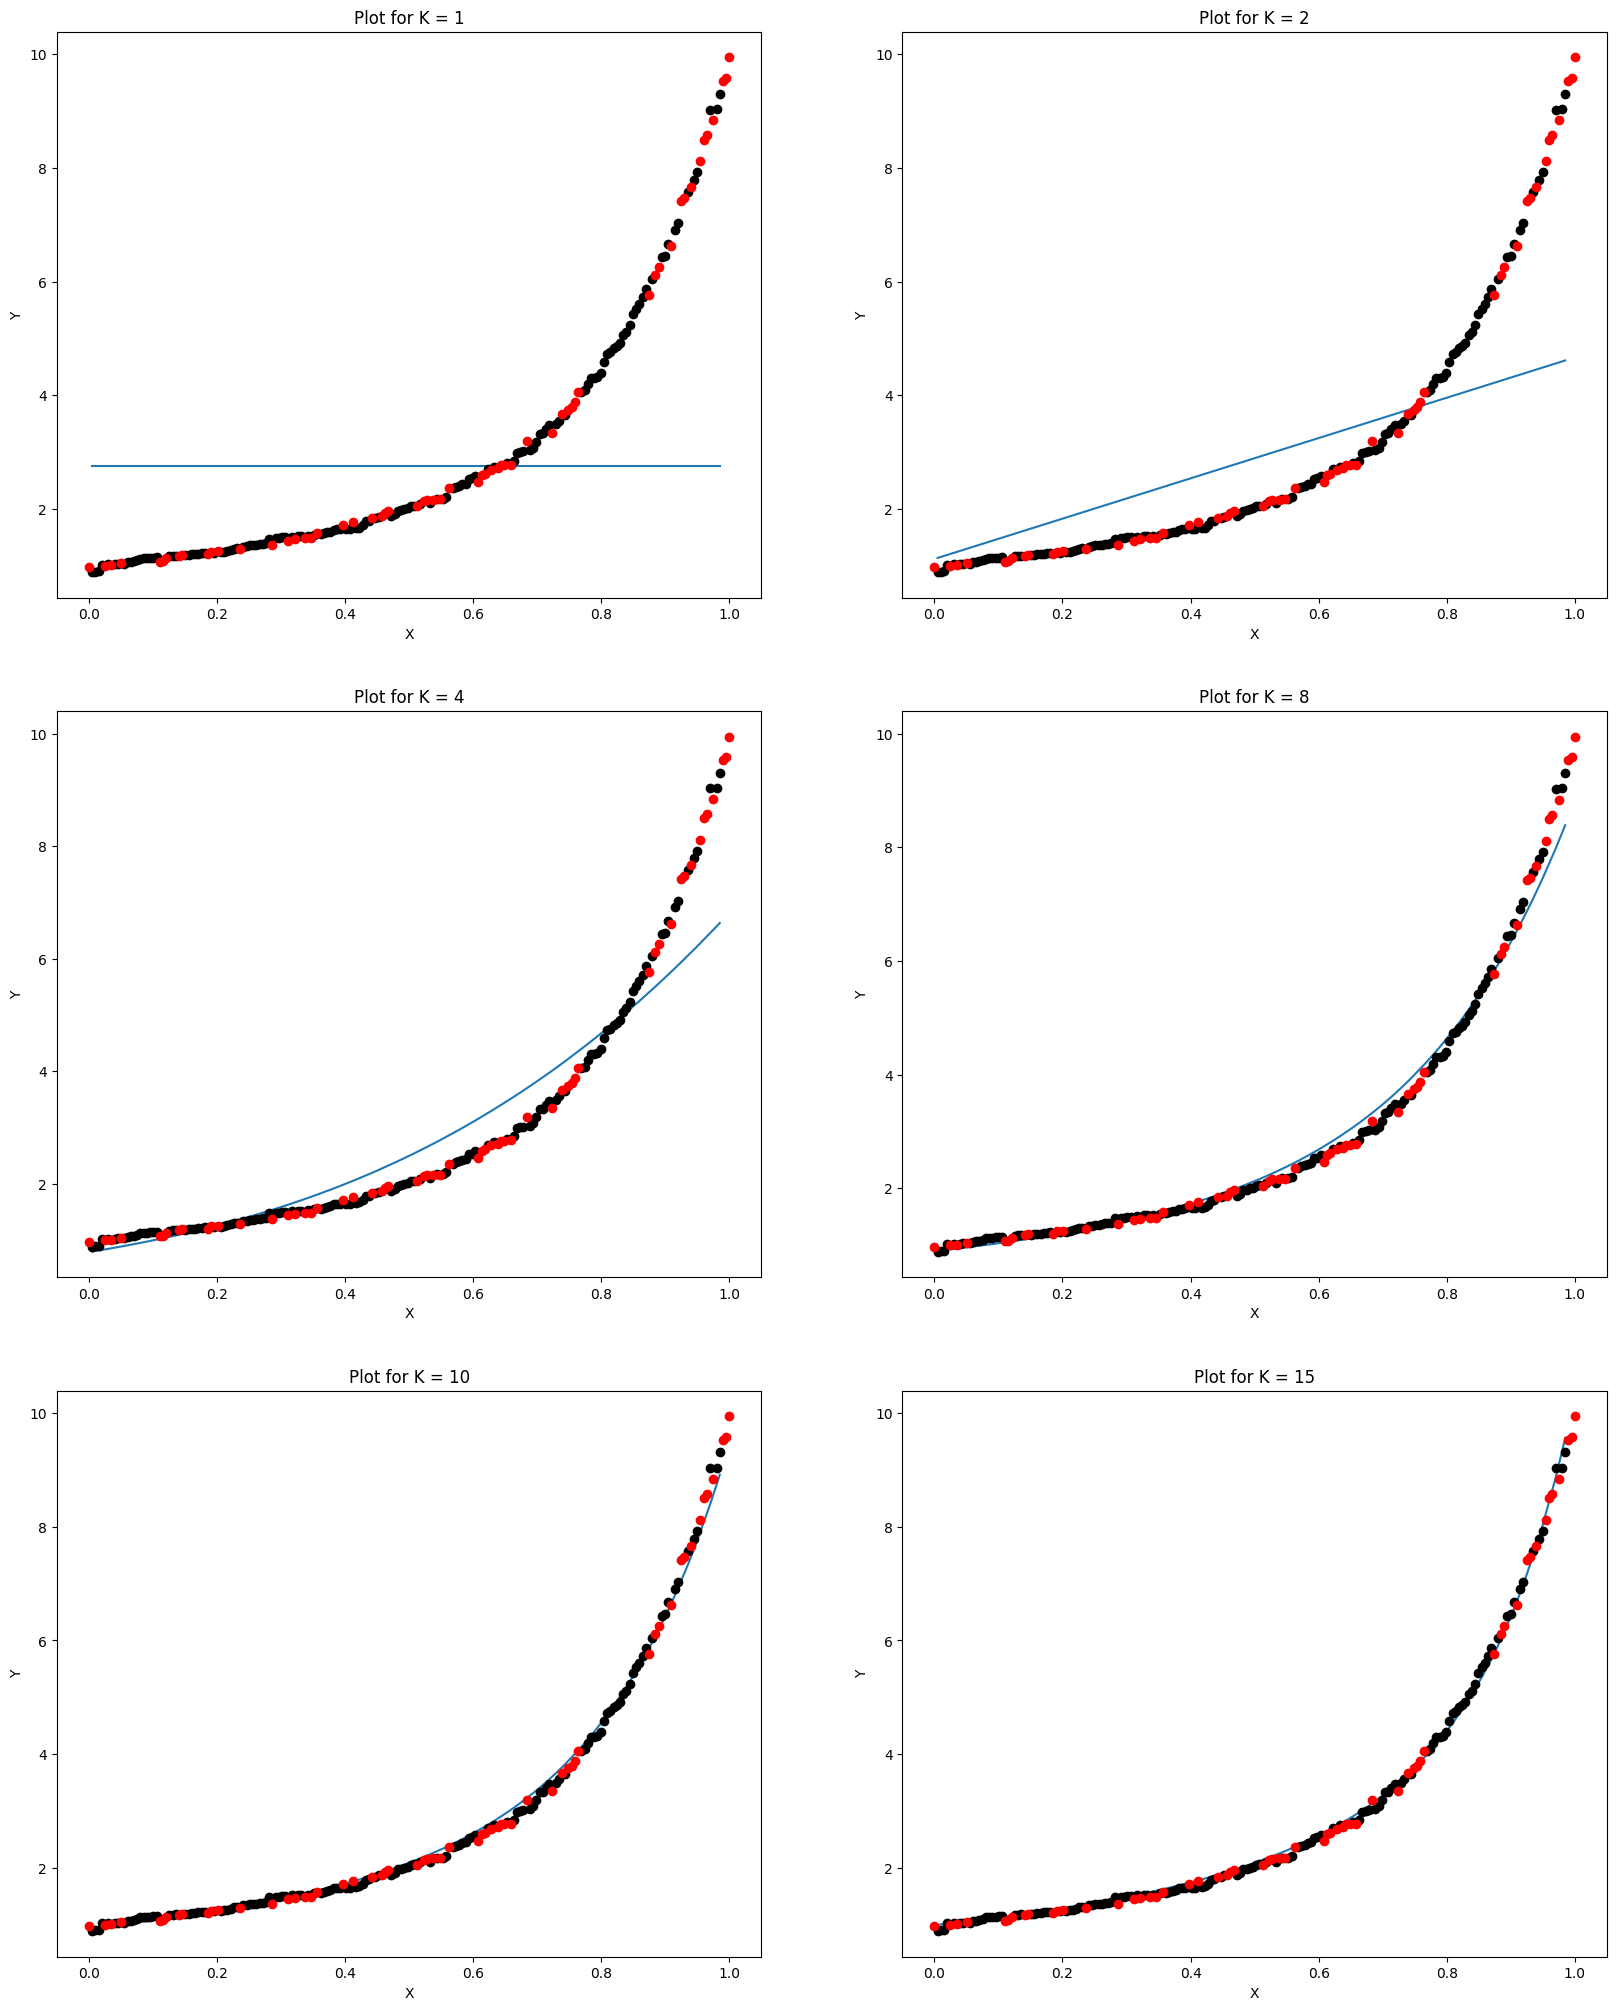

In [10]:
cnt = 0
SGD_train_error = []
SGD_test_error = []
plt.figure(figsize=(20,25))
val = [1,2,4,8,10,15]
for i in val:
    cnt += 1
    K = i
    theta_zero = np.zeros((K ,1))
    theta_comp = SGD(grad_f, theta_zero, 0, (X_train,Y_train), 50, 100, 1e-4)
    y_pred_train = vand(X_train,K)@ theta_comp
    SGD_train_error.append(abs_avg_error(X_train,theta_comp,Y_train))
    SGD_test_error.append(abs_avg_error(X_test,theta_comp,Y_test))
    plt.subplot(3,2,cnt)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.plot(sorted(X_train),sorted(y_pred_train))
    plt.plot(sorted(X_train),sorted(Y_train),"ko")
    plt.plot(sorted(X_test),sorted(Y_test),"o",color="red")
    plt.title(f"Plot for K = {i}")
plt.show()

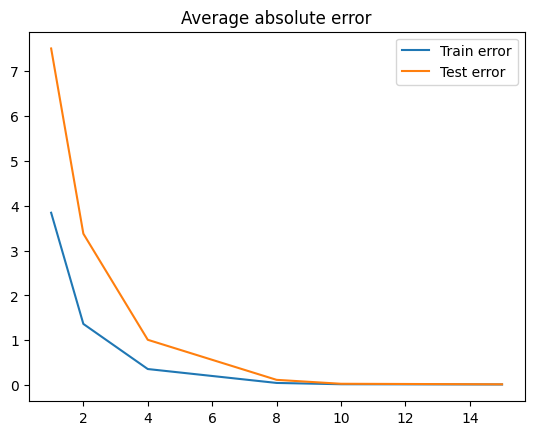

In [11]:
plt.plot(val,SGD_train_error,label="Train error")
plt.plot(val,SGD_test_error,label="Test error")
plt.title("Average absolute error")
plt.legend()
plt.show()

### MLE with GD

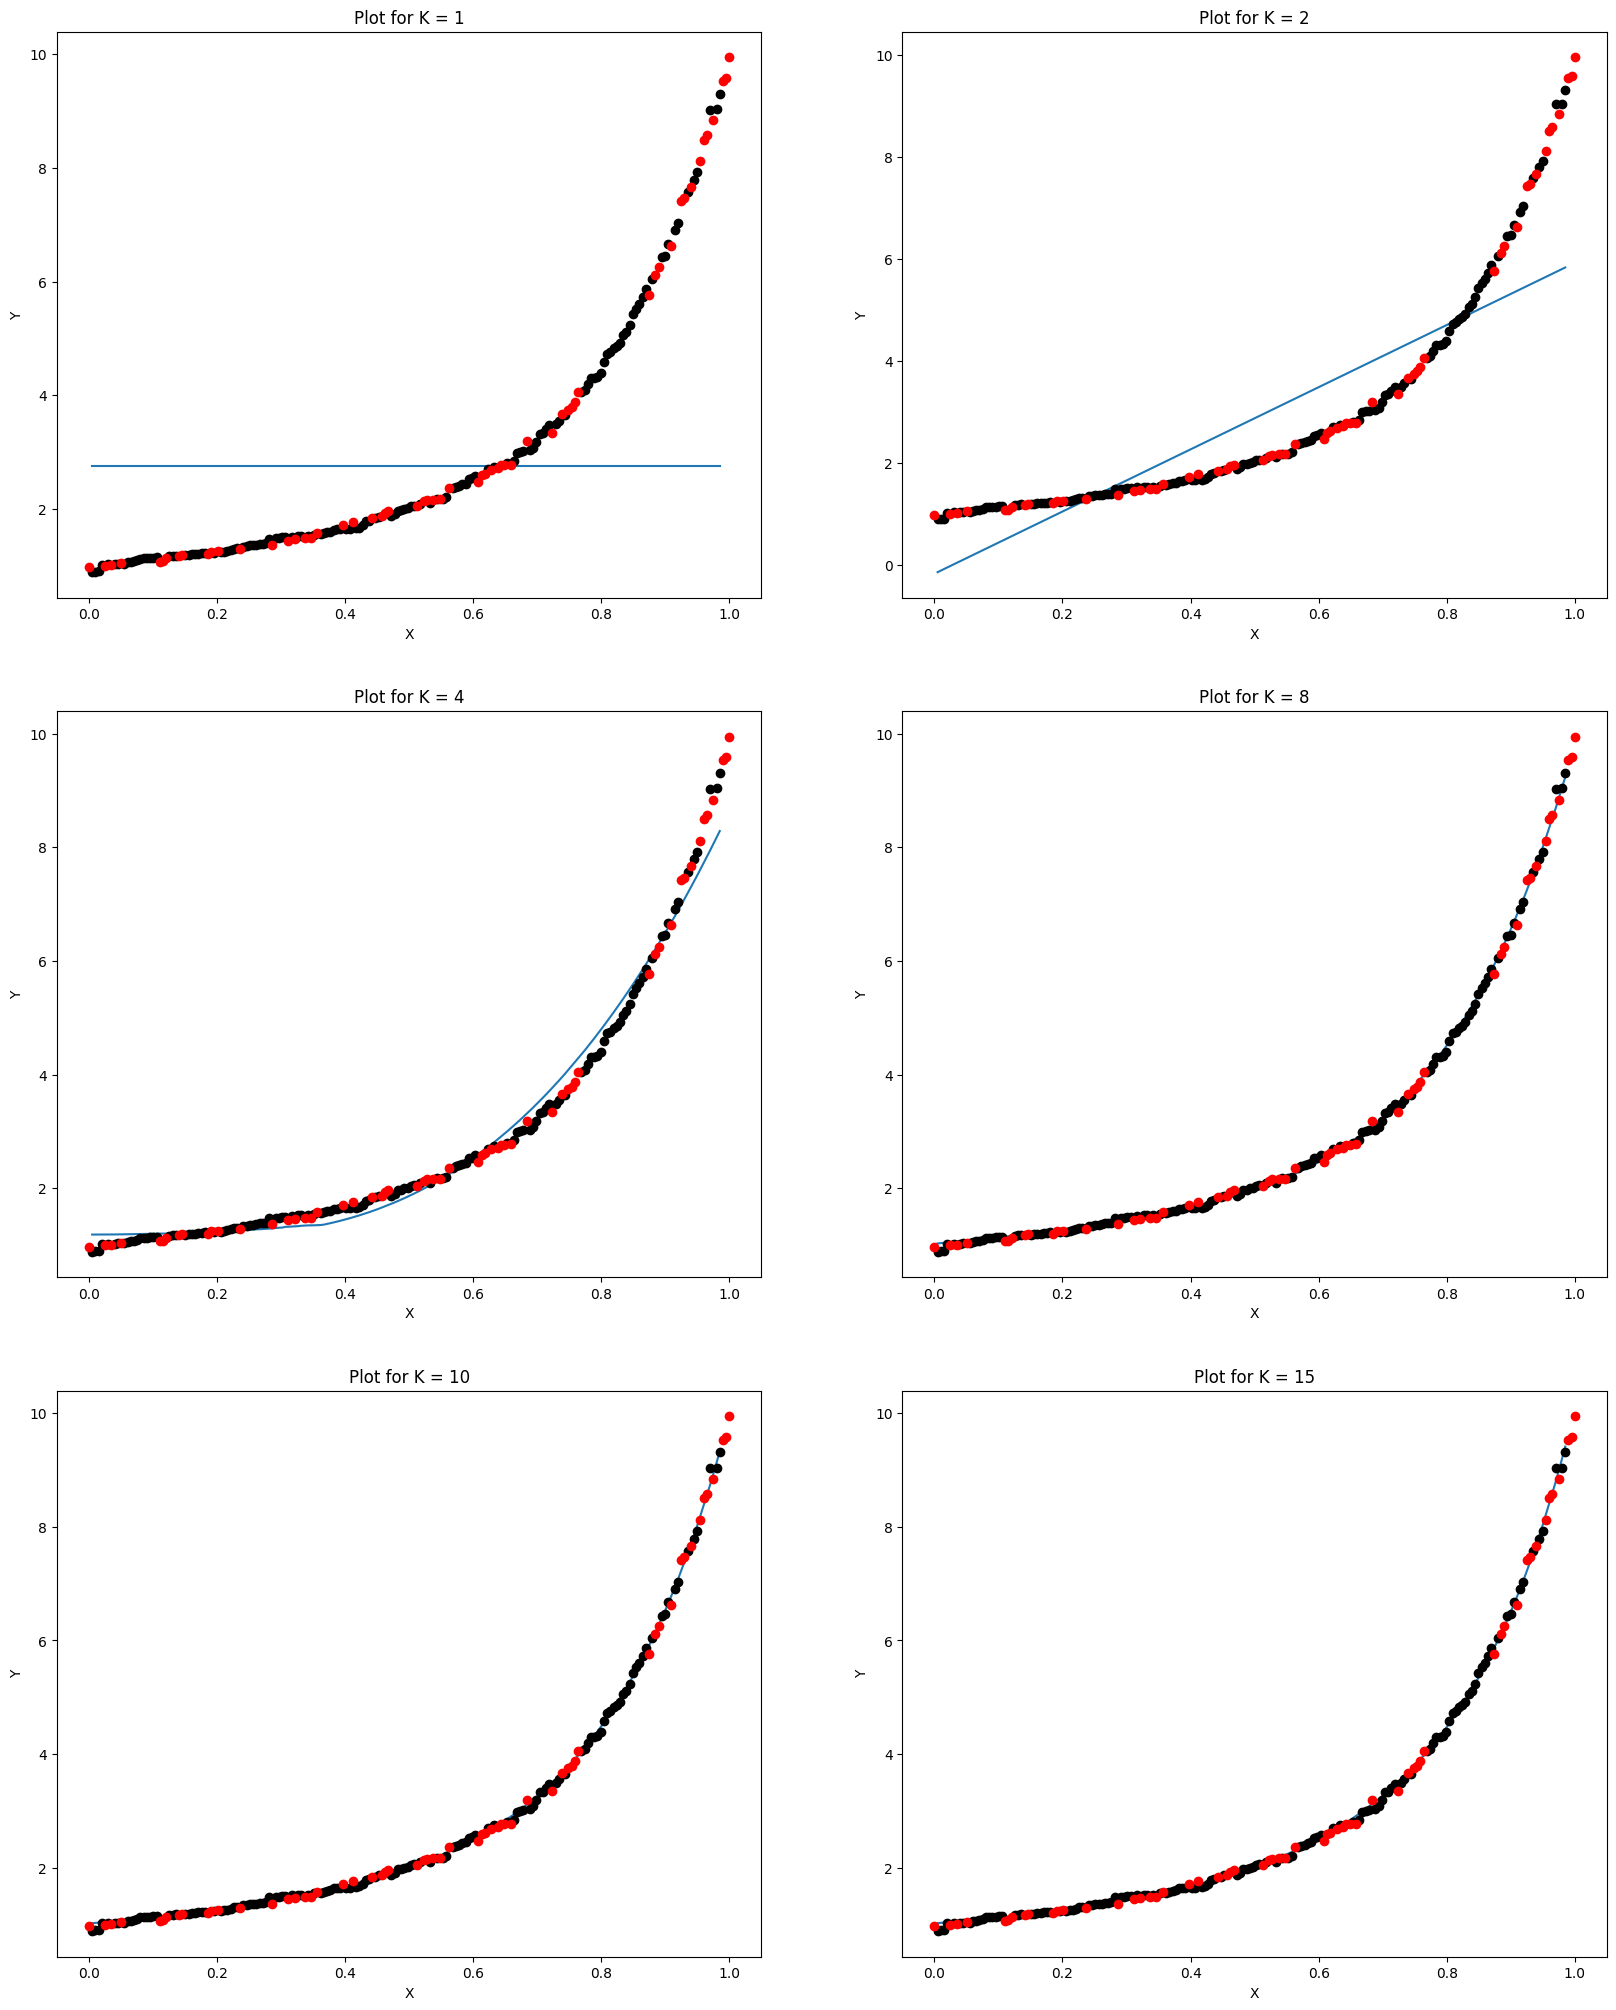

In [12]:
cnt = 0
GD_train_error = []
GD_test_error = []
plt.figure(figsize=(20,25))
val = [1,2,4,8,10,15]
for i in val:
    cnt += 1
    K = i
    theta_zero = np.zeros((K ,1))
    theta_comp = GD(grad_f, theta_zero,0, (X_train,Y_train),  100000, 1e-5, 1e-5, 0.00001)
    y_pred_train = vand(X_train,K)@ theta_comp
    GD_train_error.append(abs_avg_error(X_train,theta_comp,Y_train))
    GD_test_error.append(abs_avg_error(X_test,theta_comp,Y_test))
    plt.subplot(3,2,cnt)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.plot(sorted(X_train),sorted(y_pred_train))
    plt.plot(sorted(X_train),sorted(Y_train),"ko")
    plt.plot(sorted(X_test),sorted(Y_test),"o",color="red")
    plt.title(f"Plot for K = {i}")
plt.show()

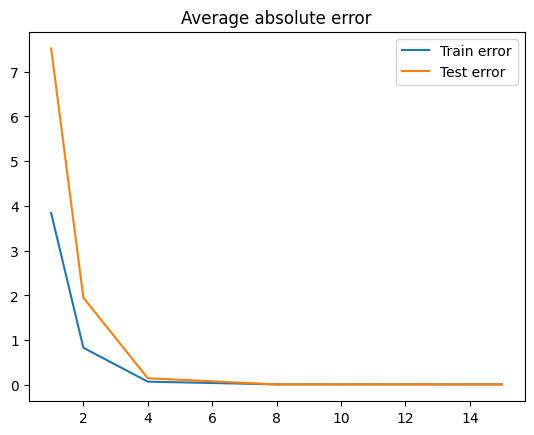

In [13]:
plt.plot(val,GD_train_error,label="Train error")
plt.plot(val,GD_test_error,label="Test error")
plt.title("Average absolute error")
plt.legend()
plt.show()

### MLE with Normal Equations

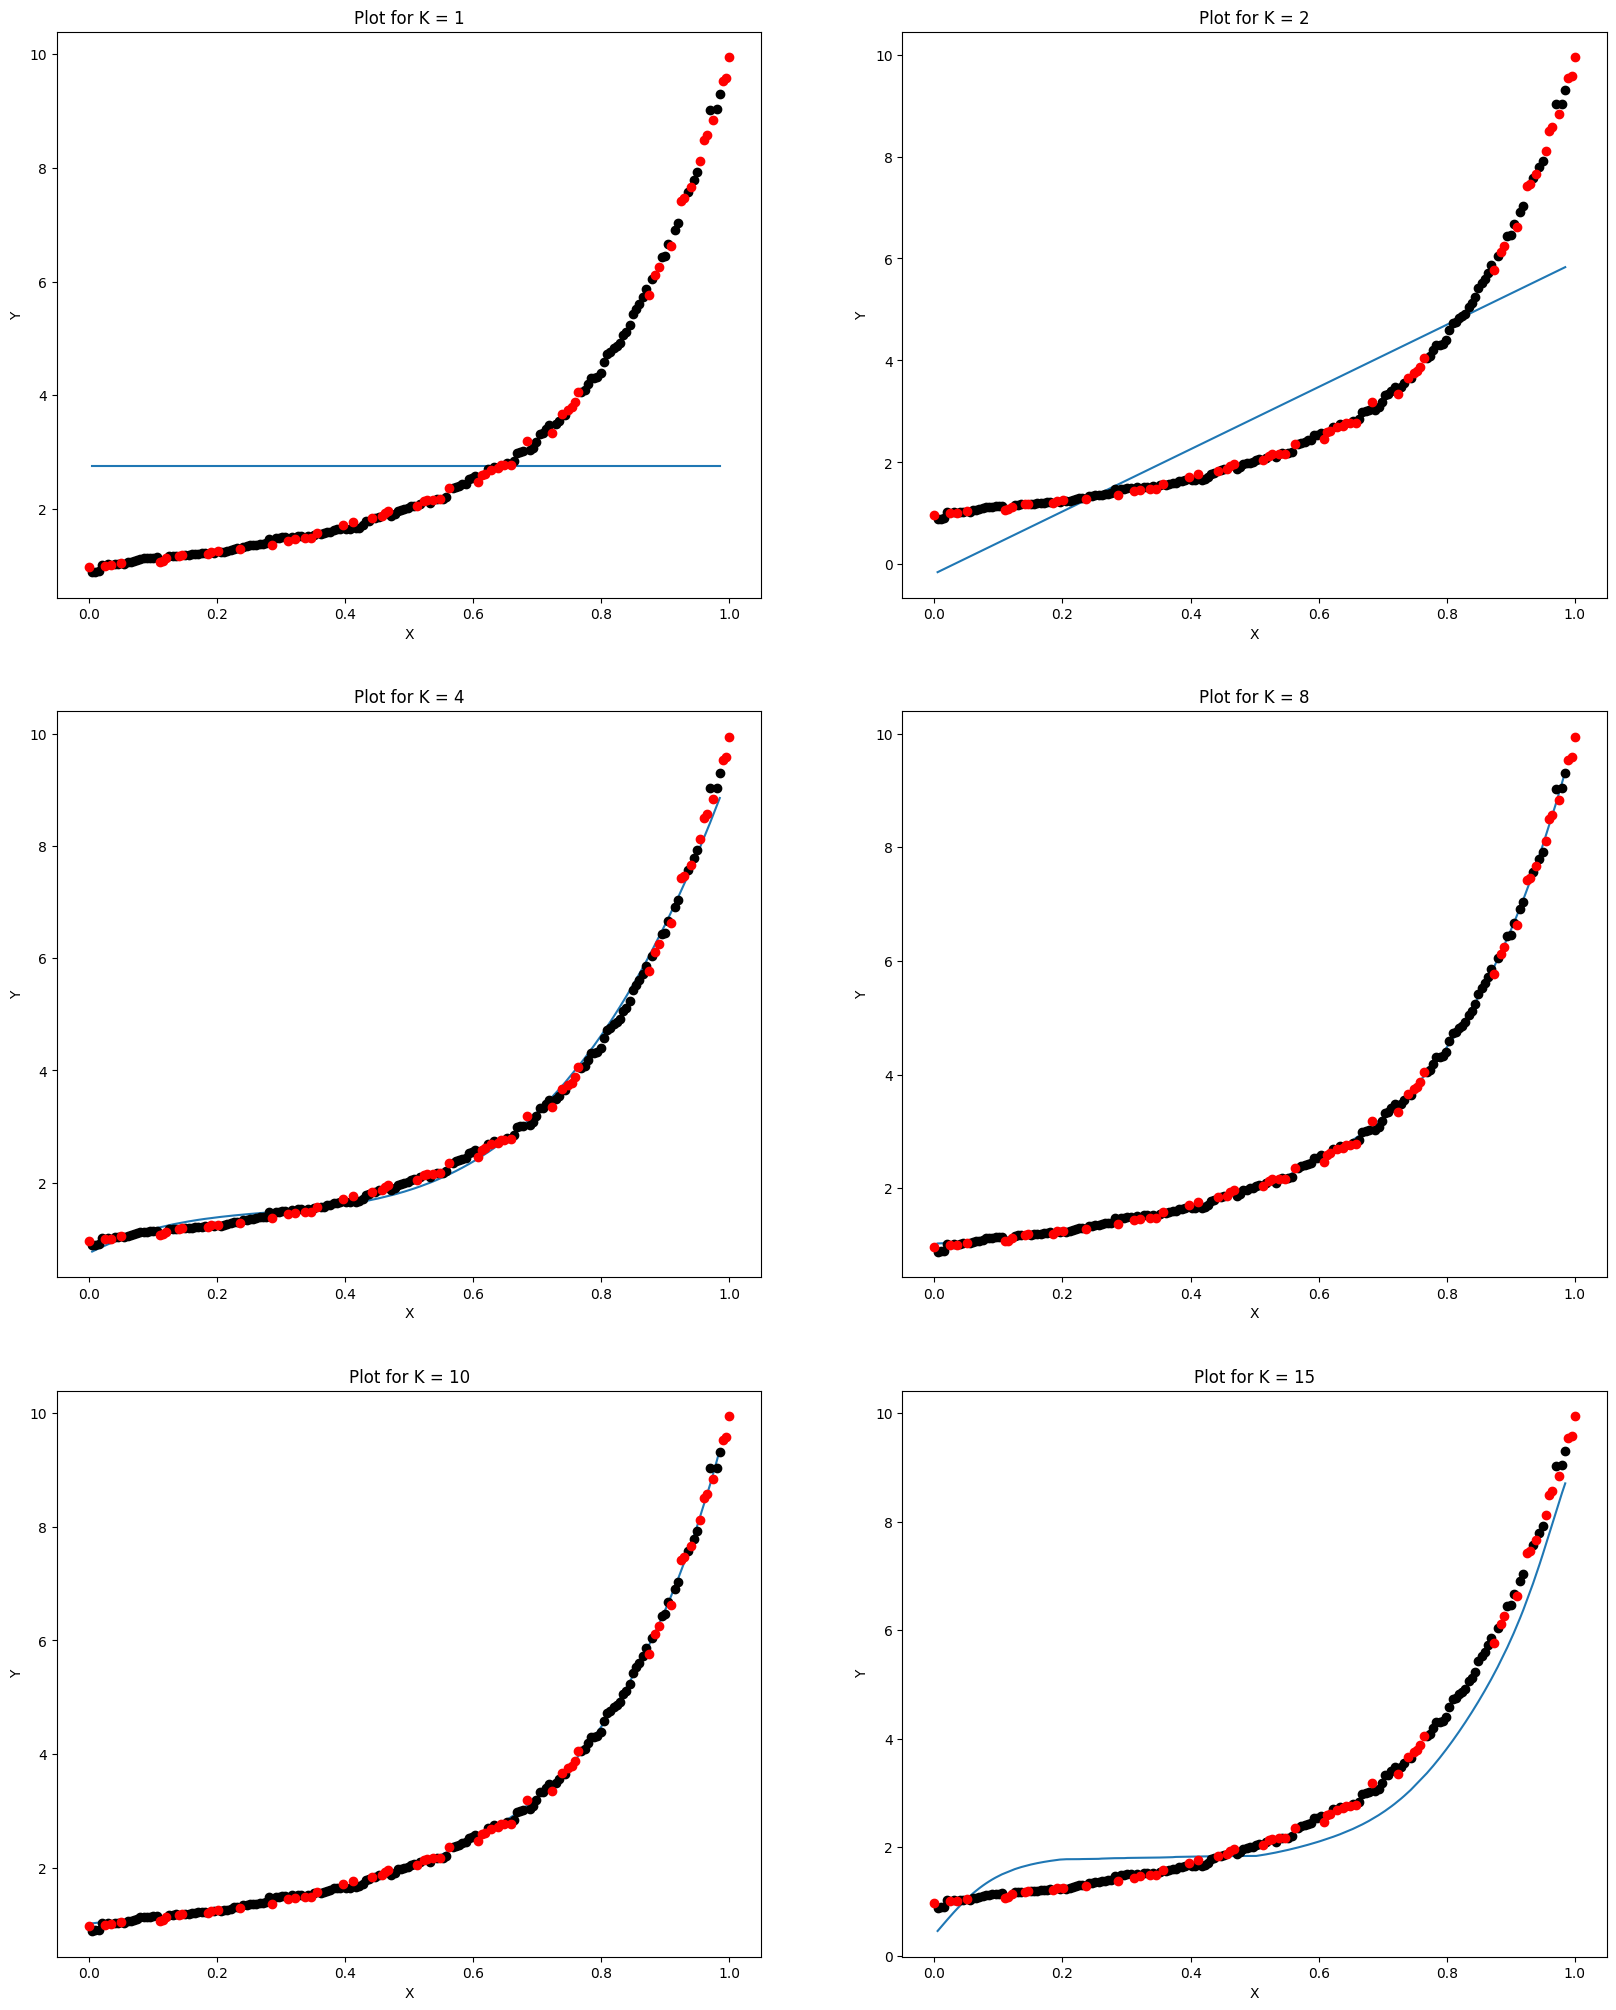

In [14]:
cnt = 0
NE_train_error = []
NE_test_error = []
plt.figure(figsize=(20,25))
val = [1,2,4,8,10,15]
for i in val:
    cnt += 1
    K = i
    theta_zero = np.zeros((K ,1))
    theta_comp = NE(X_train,Y_train,K)
    y_pred_train = vand(X_train,K)@ theta_comp
    NE_train_error.append(abs_avg_error(X_train,theta_comp,Y_train))
    NE_test_error.append(abs_avg_error(X_test,theta_comp,Y_test))
    plt.subplot(3,2,cnt)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.plot(sorted(X_train),sorted(y_pred_train))
    plt.plot(sorted(X_train),sorted(Y_train),"ko")
    plt.plot(sorted(X_test),sorted(Y_test),"o",color="red")
    plt.title(f"Plot for K = {i}")
plt.show()

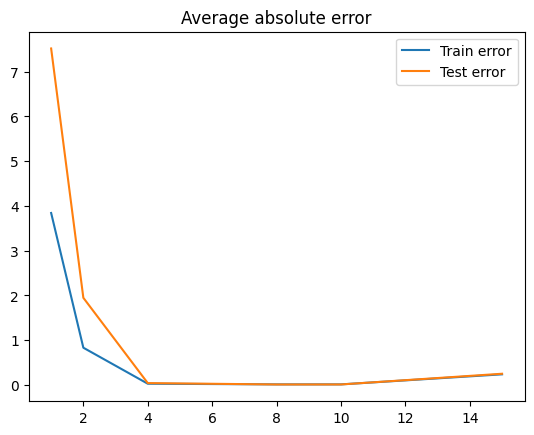

In [15]:
plt.plot(val,NE_train_error,label="Train error")
plt.plot(val,NE_test_error,label="Test error")
plt.title("Average absolute error")
plt.legend()
plt.show()

### MAP with SGD

In [16]:
def f_MAP(X,Y,theta,lmbda,sigma_2=sigma_2):
    k = theta.shape[0]
    phi=vand(X,k)
    return (np.linalg.norm(phi@theta-Y,2)**2 + (lmbda*np.linalg.norm(theta,2)**2))/2


In [17]:
def grad_MAP(X,Y,theta,lmbda,sigma_2=sigma_2):
    k = theta.shape[0]
    phi=vand(X,k)
    return  phi.T@(phi@theta-Y) + lmbda*theta

### -Train and Test datapoints plot and learnt model plot for different K

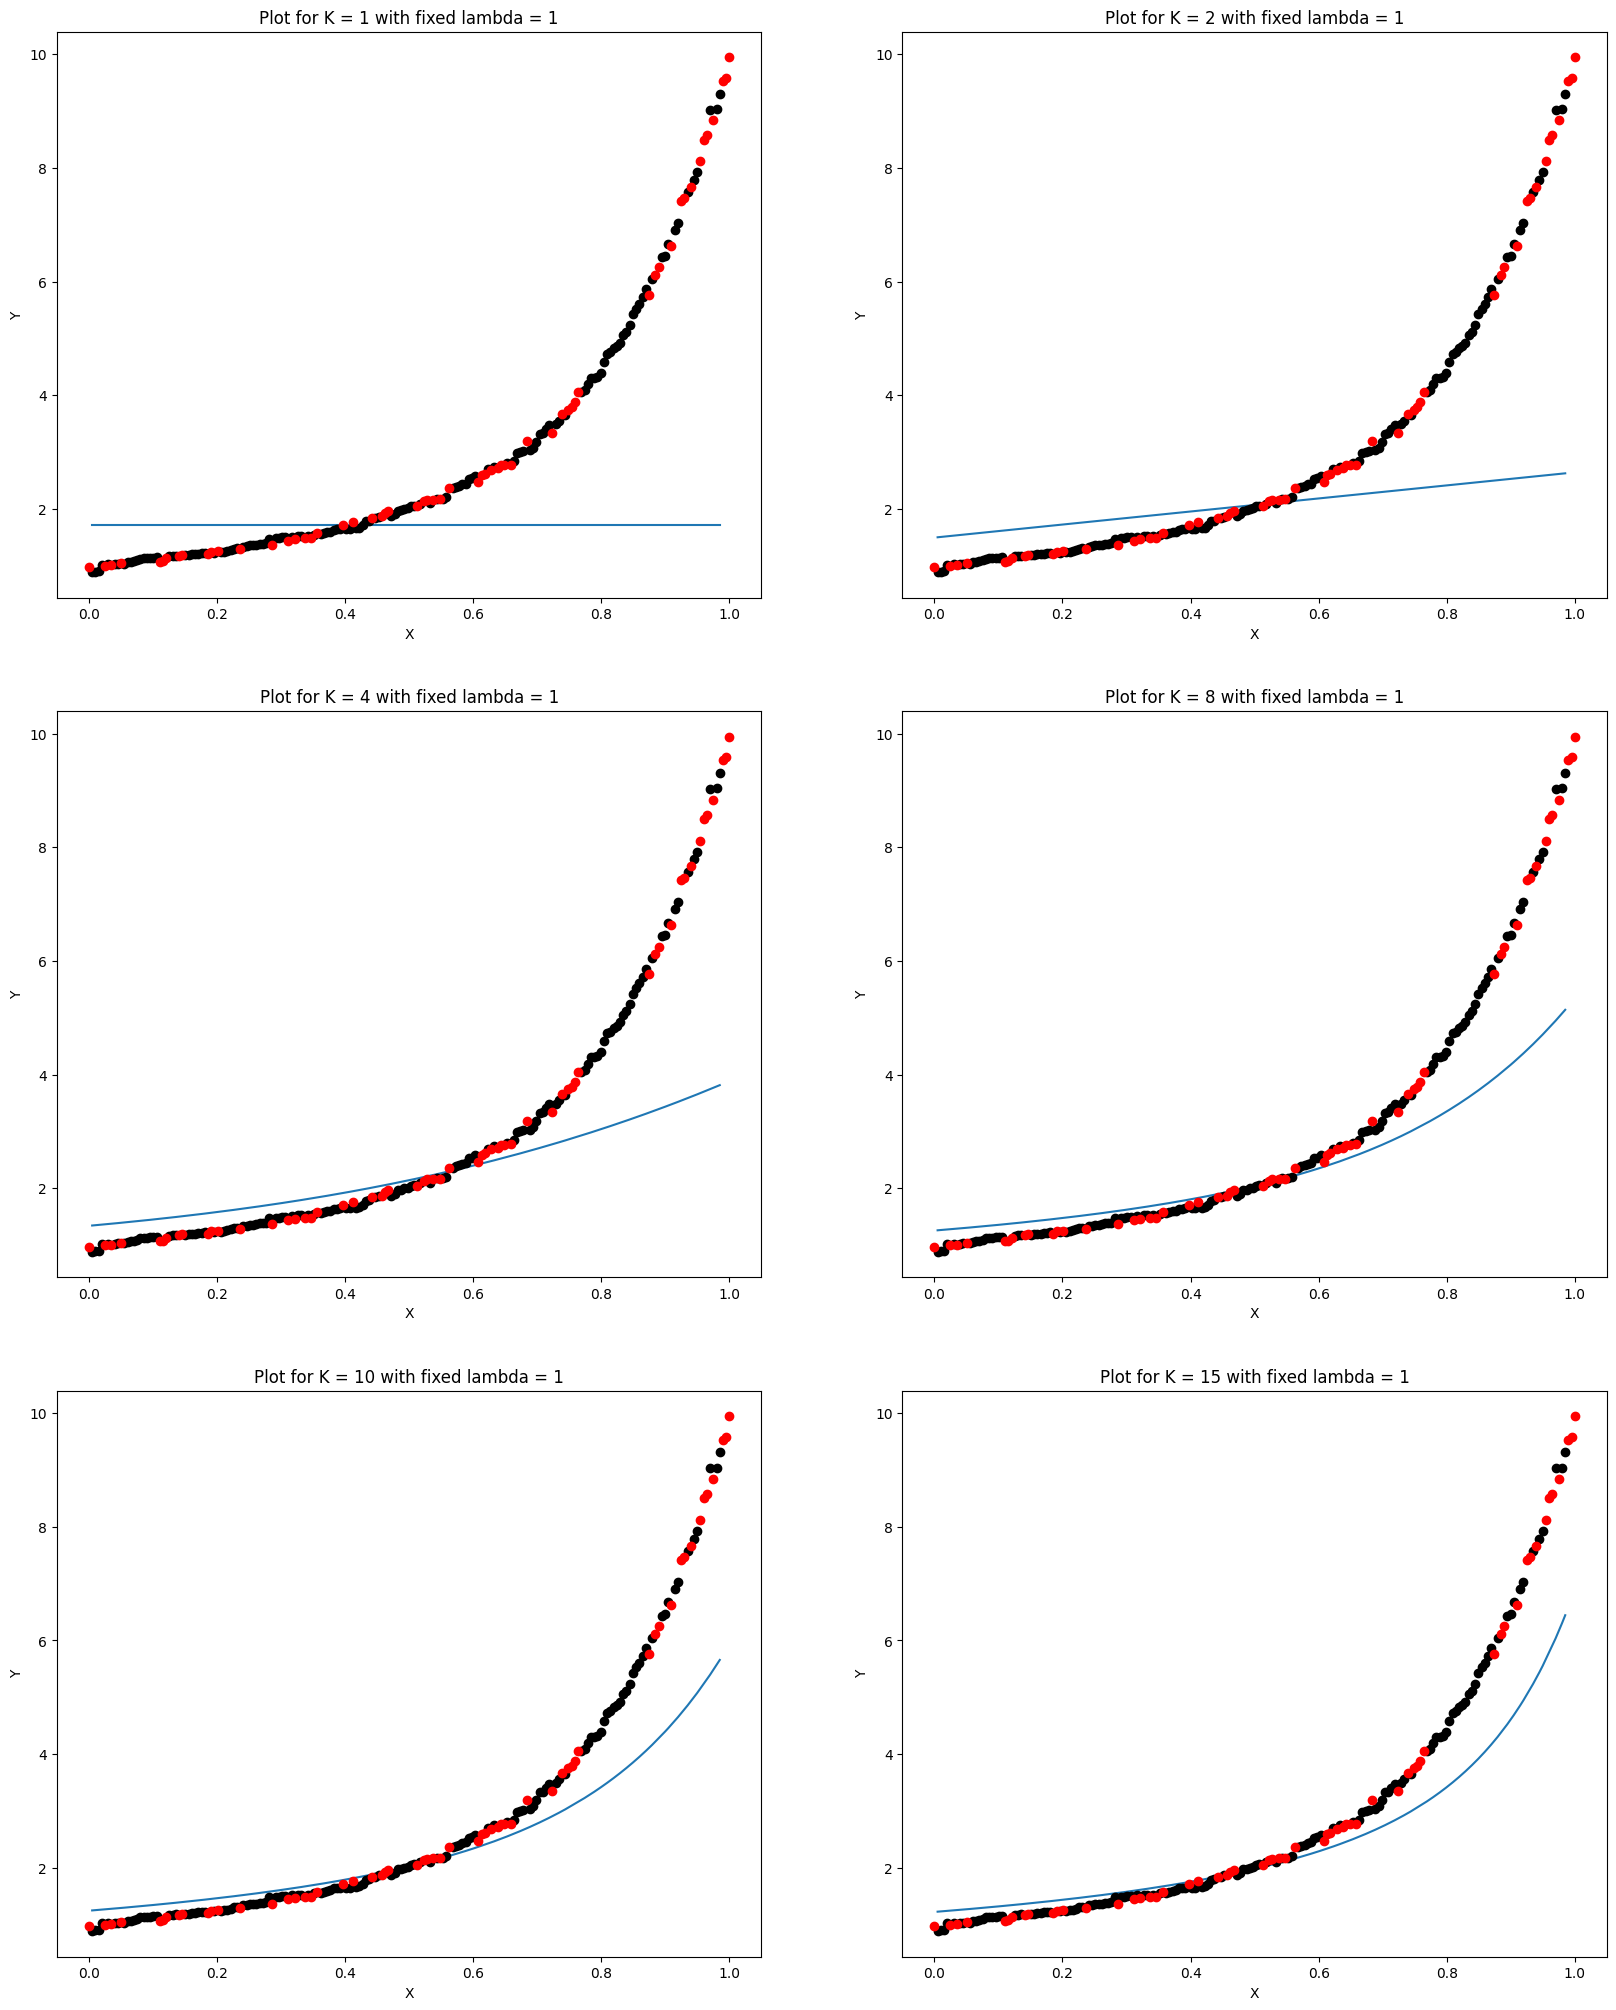

In [18]:
cnt = 0
lmbda = 1
MAP_SGD_train_error = []
MAP_SGD_test_error = []
plt.figure(figsize=(20,25))
val = [1,2,4,8,10,15]
for i in val:
    cnt += 1
    K = i
    theta_zero = np.zeros((K ,1))
    theta_comp = SGD(grad_MAP, theta_zero, lmbda, (X_train,Y_train), 50, 100, 1e-4)
    y_pred_train = vand(X_train,K)@ theta_comp
    MAP_SGD_train_error.append(abs_avg_error(X_train,theta_comp,Y_train))
    MAP_SGD_test_error.append(abs_avg_error(X_test,theta_comp,Y_test))
    plt.subplot(3,2,cnt)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.plot(sorted(X_train),sorted(y_pred_train))
    plt.plot(sorted(X_train),sorted(Y_train),"ko")
    plt.plot(sorted(X_test),sorted(Y_test),"o",color="red")
    plt.title(f"Plot for K = {i} with fixed lambda = {lmbda}")
plt.show()

### -Error plot for different K

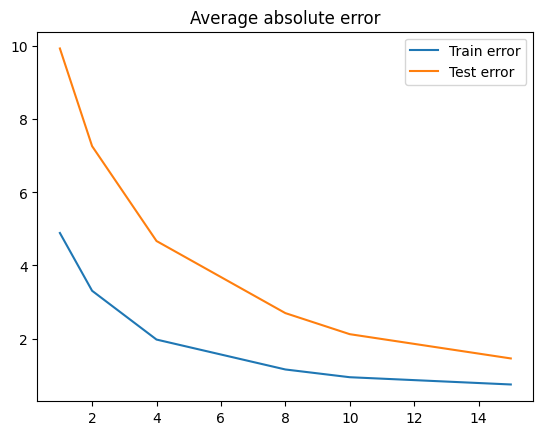

In [19]:
plt.plot(val,MAP_SGD_train_error,label="Train error")
plt.plot(val,MAP_SGD_test_error,label="Test error")
plt.title("Average absolute error")
plt.legend()
plt.show()

### -Train and Test datapoints plot and learnt model plot for different lambda(regularization factor)

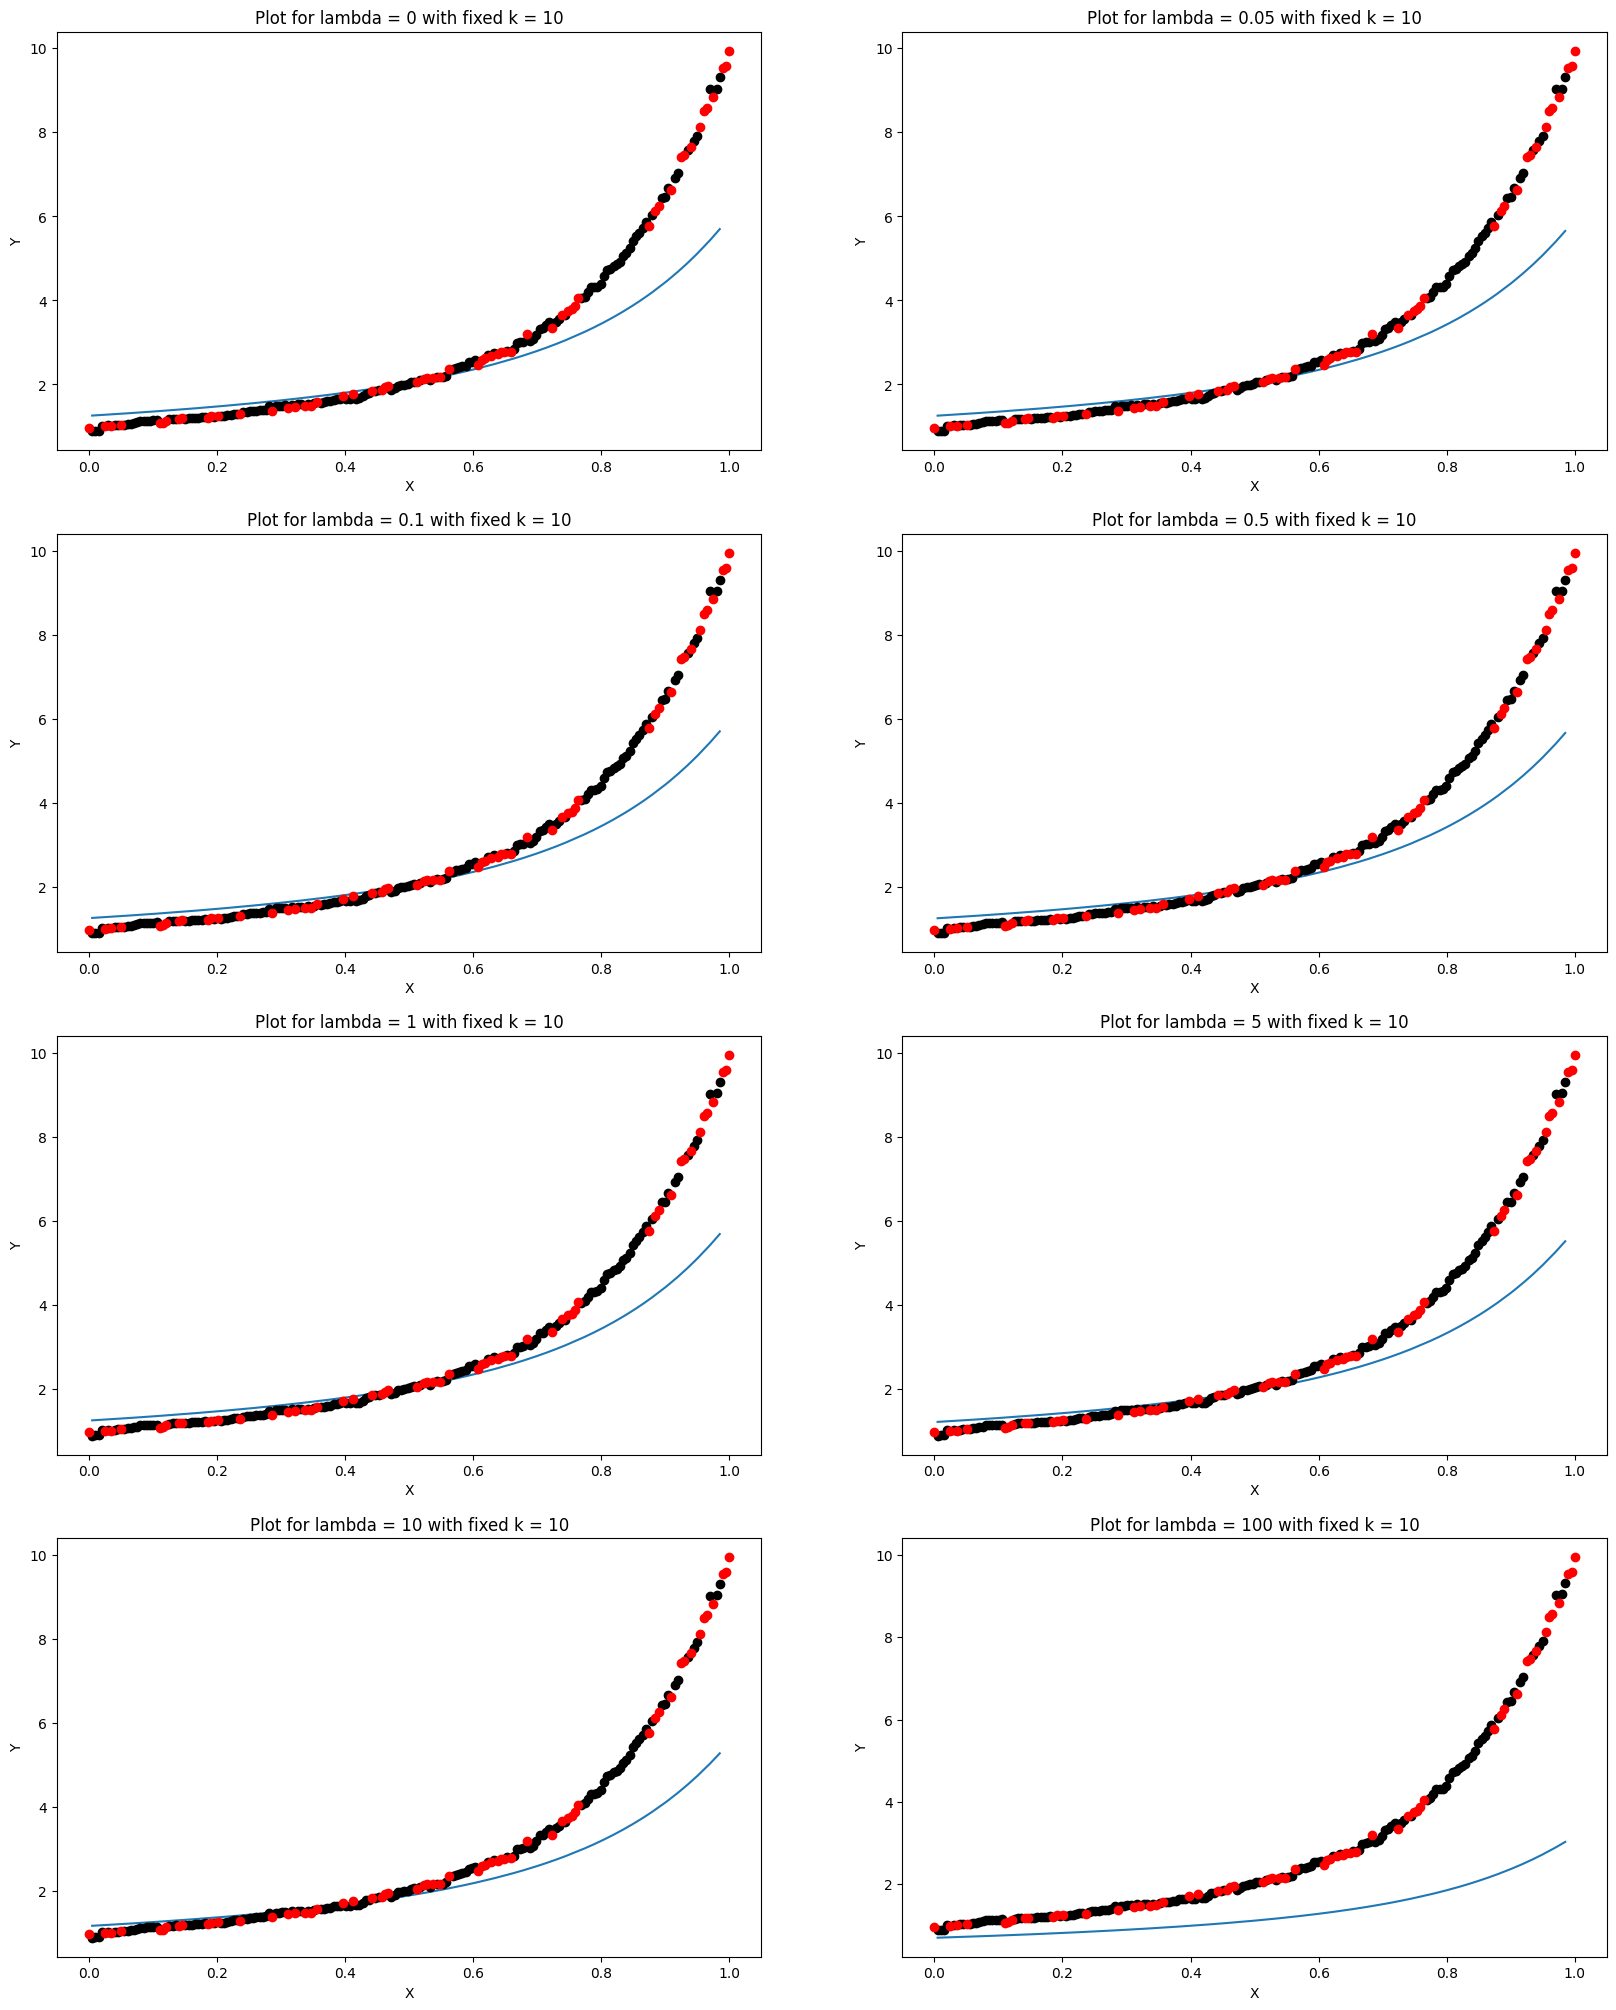

In [20]:
cnt = 0
MAP_SGD_train_error = []
MAP_SGD_test_error = []
plt.figure(figsize=(20,25))
val = [0,0.05,0.1,0.5,1,5,10,100]
for i in val:
    cnt += 1
    K = 10
    lmbda = i
    theta_zero = np.zeros((K ,1))
    theta_comp = SGD(grad_MAP, theta_zero, lmbda, (X_train,Y_train), 50, 100, 1e-4)
    y_pred_train = vand(X_train,K)@ theta_comp
    MAP_SGD_train_error.append(abs_avg_error(X_train,theta_comp,Y_train))
    MAP_SGD_test_error.append(abs_avg_error(X_test,theta_comp,Y_test))
    plt.subplot(4,2,cnt)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.plot(sorted(X_train),sorted(y_pred_train))
    plt.plot(sorted(X_train),sorted(Y_train),"ko")
    plt.plot(sorted(X_test),sorted(Y_test),"o",color="red")
    plt.title(f"Plot for lambda = {i} with fixed k = {K}")
plt.show()

### -Error plot for different lambda

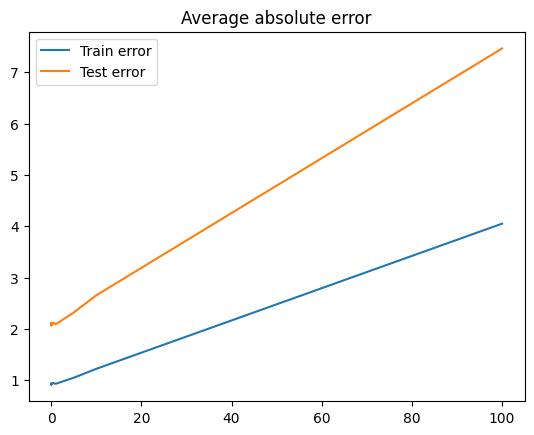

In [21]:
plt.plot(val,MAP_SGD_train_error,label="Train error")
plt.plot(val,MAP_SGD_test_error,label="Test error")
plt.title("Average absolute error")
plt.legend()
plt.show()

### MAP with GD

### -Train and Test datapoints plot and learnt model plot for different K

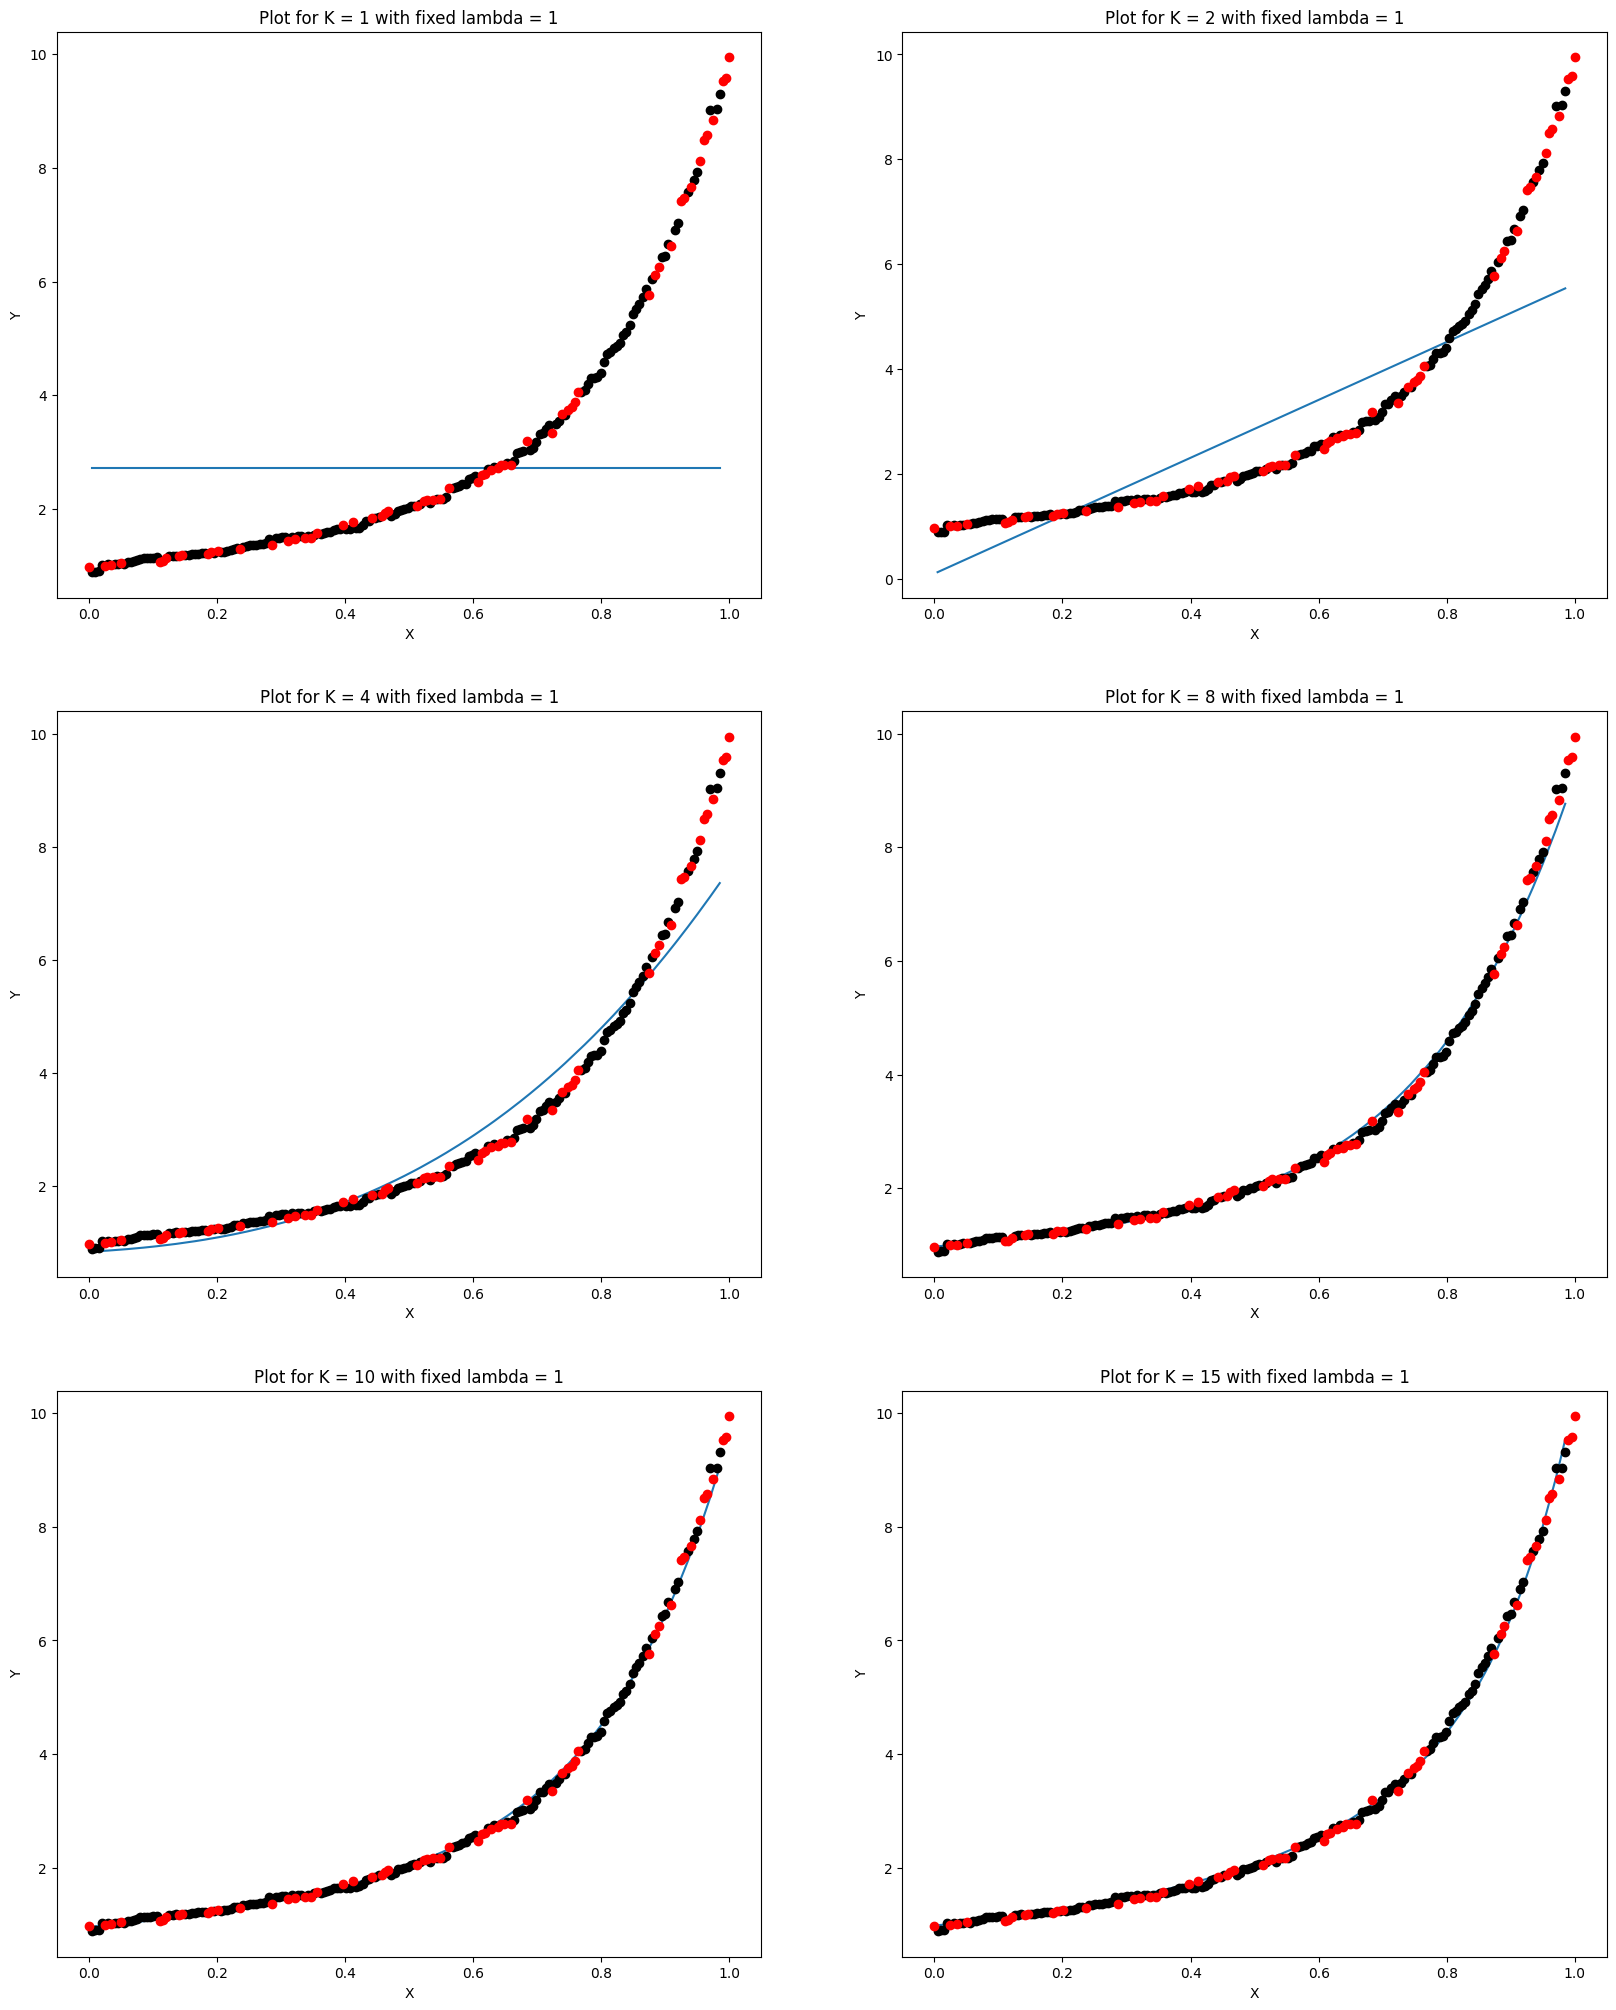

In [22]:
cnt = 0
lmbda = 1
MAP_GD_train_error = []
MAP_GD_test_error = []
plt.figure(figsize=(20,25))
val = [1,2,4,8,10,15]
for i in val:
    cnt += 1
    K = i
    theta_zero = np.zeros((K ,1))
    theta_comp = GD(grad_MAP, theta_zero, lmbda, (X_train,Y_train),  100000, 1e-5, 1e-5, 0.00001)
    y_pred_train = vand(X_train,K)@ theta_comp
    MAP_GD_train_error.append(abs_avg_error(X_train,theta_comp,Y_train))
    MAP_GD_test_error.append(abs_avg_error(X_test,theta_comp,Y_test))
    plt.subplot(3,2,cnt)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.plot(sorted(X_train),sorted(y_pred_train))
    plt.plot(sorted(X_train),sorted(Y_train),"ko")
    plt.plot(sorted(X_test),sorted(Y_test),"o",color="red")
    plt.title(f"Plot for K = {i} with fixed lambda = {lmbda}")
plt.show()

### -Error plot for different K

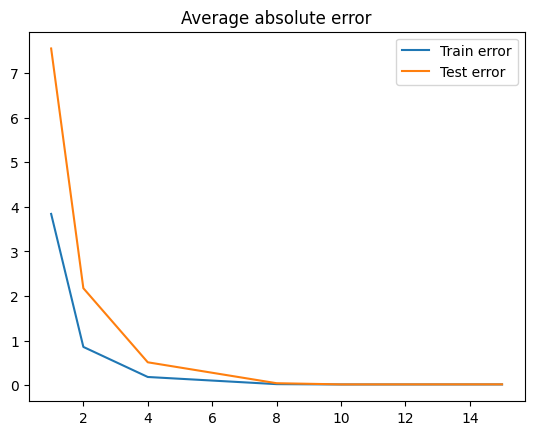

In [23]:
plt.plot(val,MAP_GD_train_error,label="Train error")
plt.plot(val,MAP_GD_test_error,label="Test error")
plt.title("Average absolute error")
plt.legend()
plt.show()

### -Train and Test datapoints plot and learnt model plot for different lambda(regularization factor)

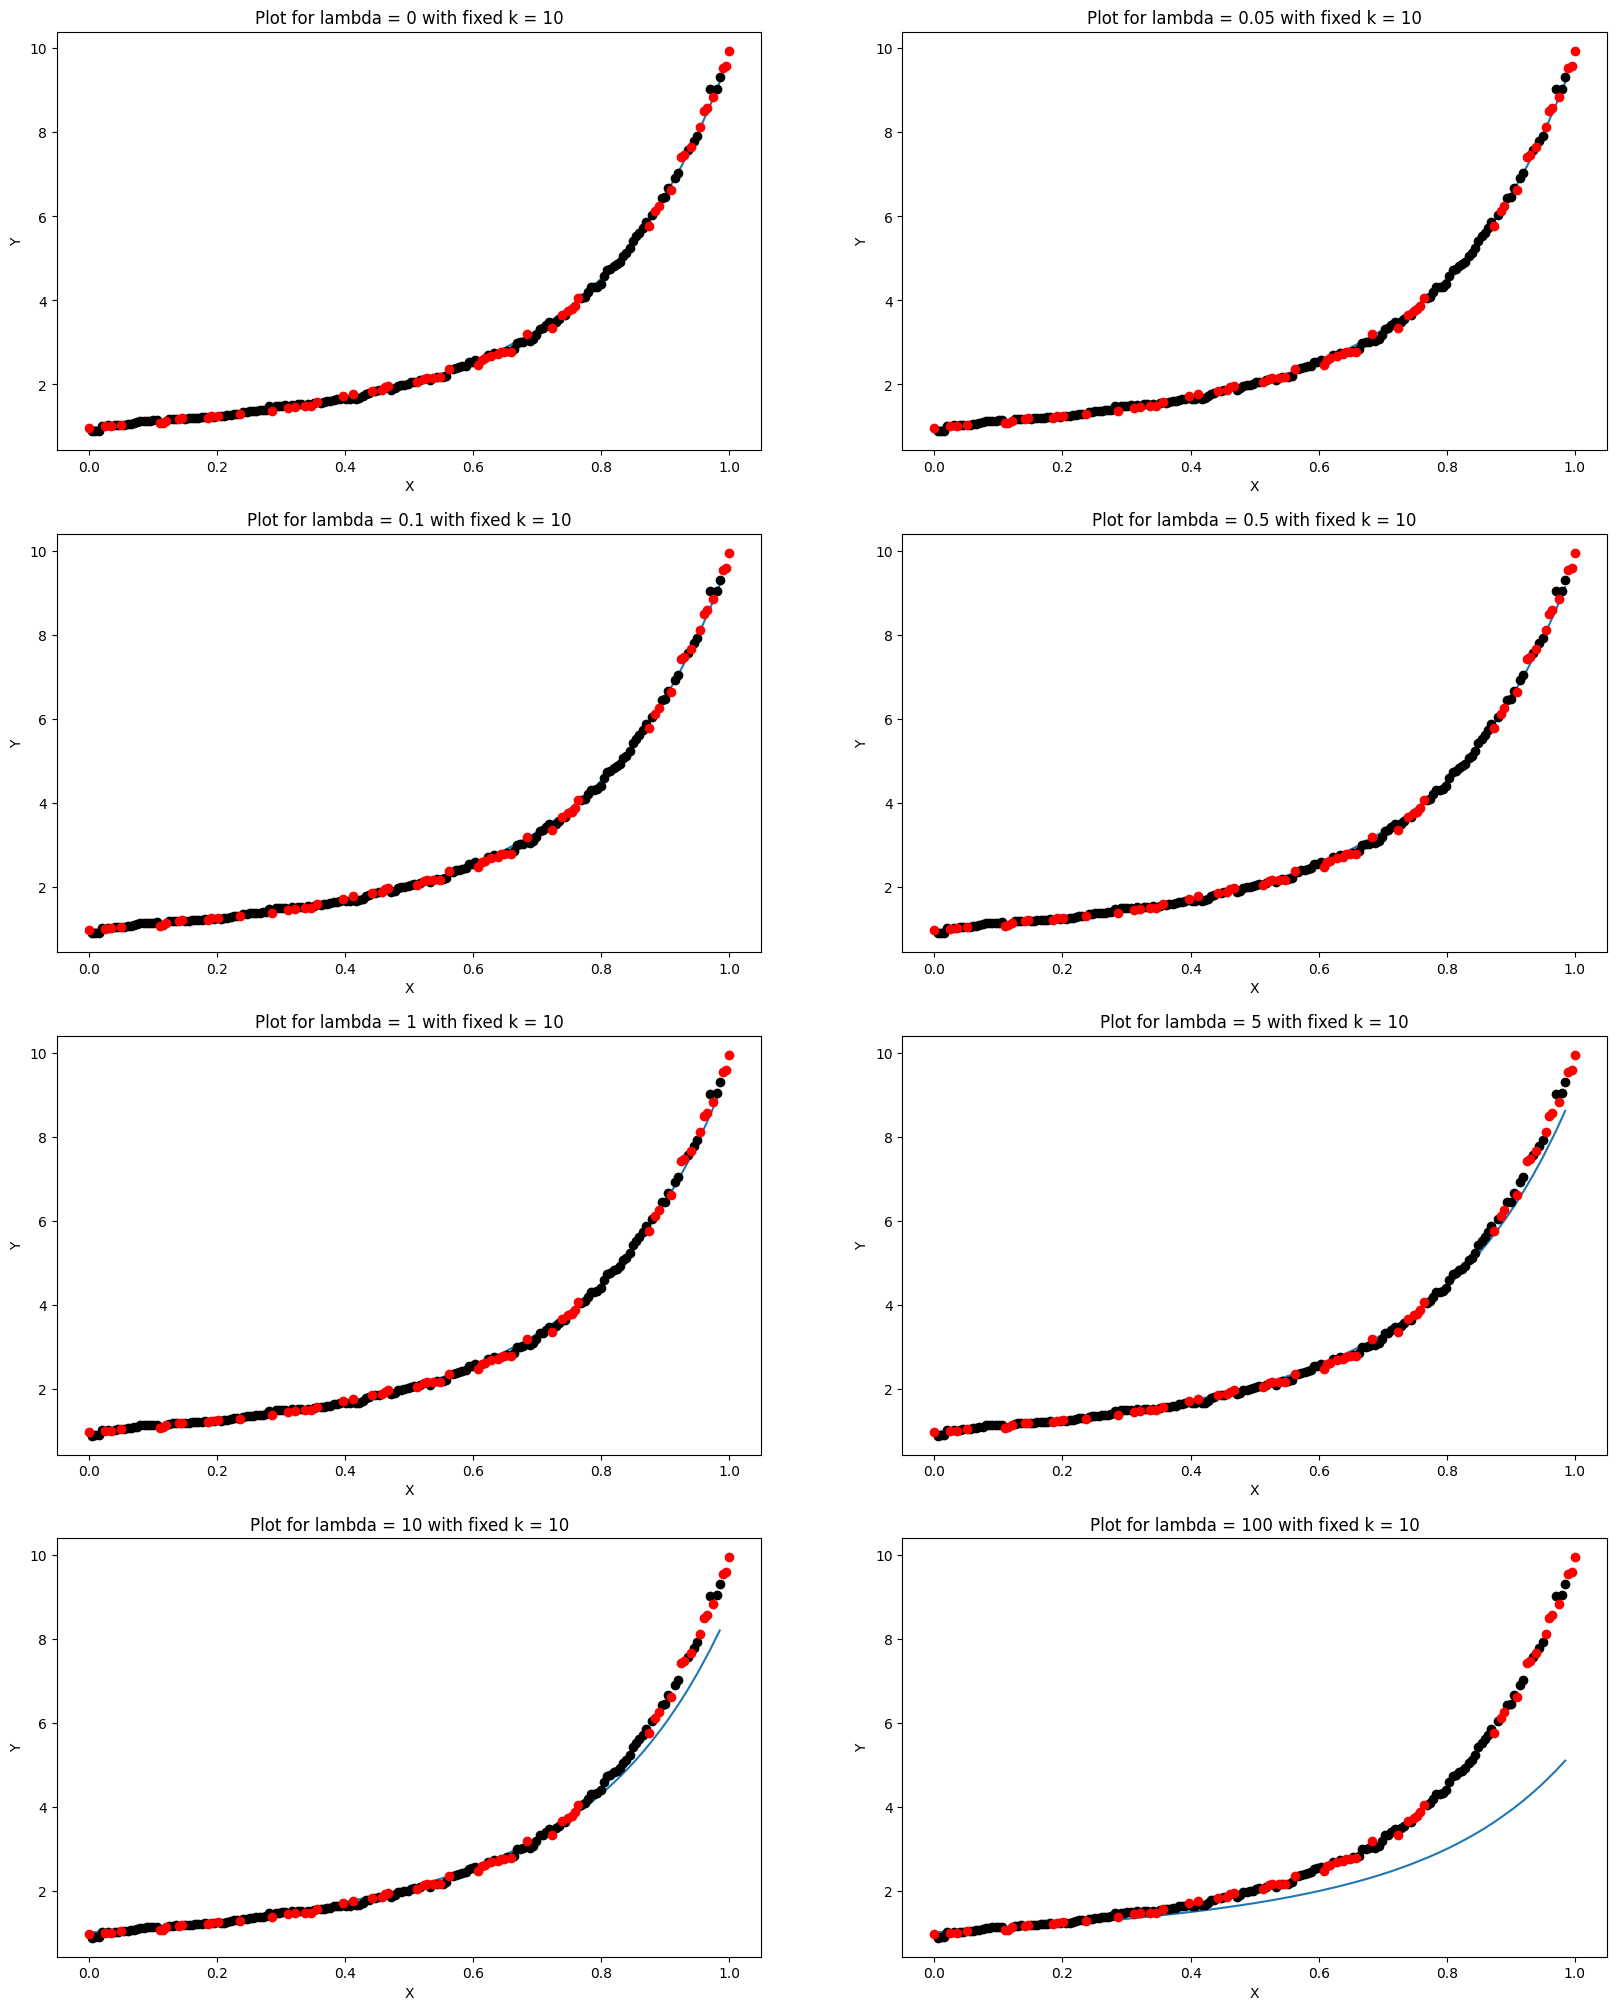

In [24]:
cnt = 0
MAP_GD_train_error = []
MAP_GD_test_error = []
plt.figure(figsize=(20,25))
val = [0,0.05,0.1,0.5,1,5,10,100]
for i in val:
    cnt += 1
    K = 10
    lmbda = i
    theta_zero = np.zeros((K ,1))
    theta_comp = GD(grad_MAP, theta_zero, lmbda, (X_train,Y_train),  100000, 1e-5, 1e-5, 0.00001)
    y_pred_train = vand(X_train,K)@ theta_comp
    MAP_GD_train_error.append(abs_avg_error(X_train,theta_comp,Y_train))
    MAP_GD_test_error.append(abs_avg_error(X_test,theta_comp,Y_test))
    plt.subplot(4,2,cnt)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.plot(sorted(X_train),sorted(y_pred_train))
    plt.plot(sorted(X_train),sorted(Y_train),"ko")
    plt.plot(sorted(X_test),sorted(Y_test),"o",color="red")
    plt.title(f"Plot for lambda = {i} with fixed k = {K}")
plt.show()

### -Error plot for different lambda

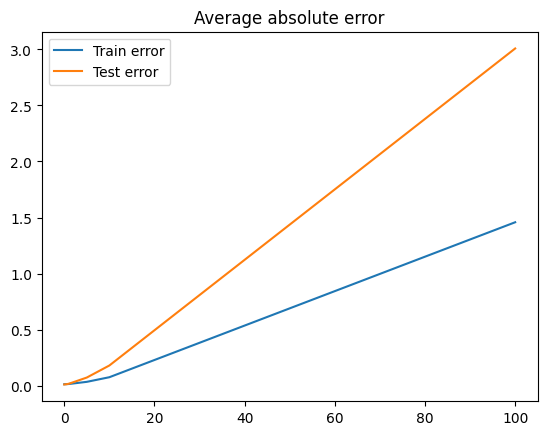

In [25]:
plt.plot(val,MAP_GD_train_error,label="Train error")
plt.plot(val,MAP_GD_test_error,label="Test error")
plt.title("Average absolute error")
plt.legend()
plt.show()

### MAP with Normal Equations

In [26]:
def MAP_NE(X,Y,K,lmbda):
    I = np.diag(np.diag(np.ones((K,K))))
    phi=vand(X,K)
    return np.linalg.inv(phi.T @ phi + lmbda*I) @ phi.T @ Y

### -Train and Test datapoints plot and learnt model plot for different K

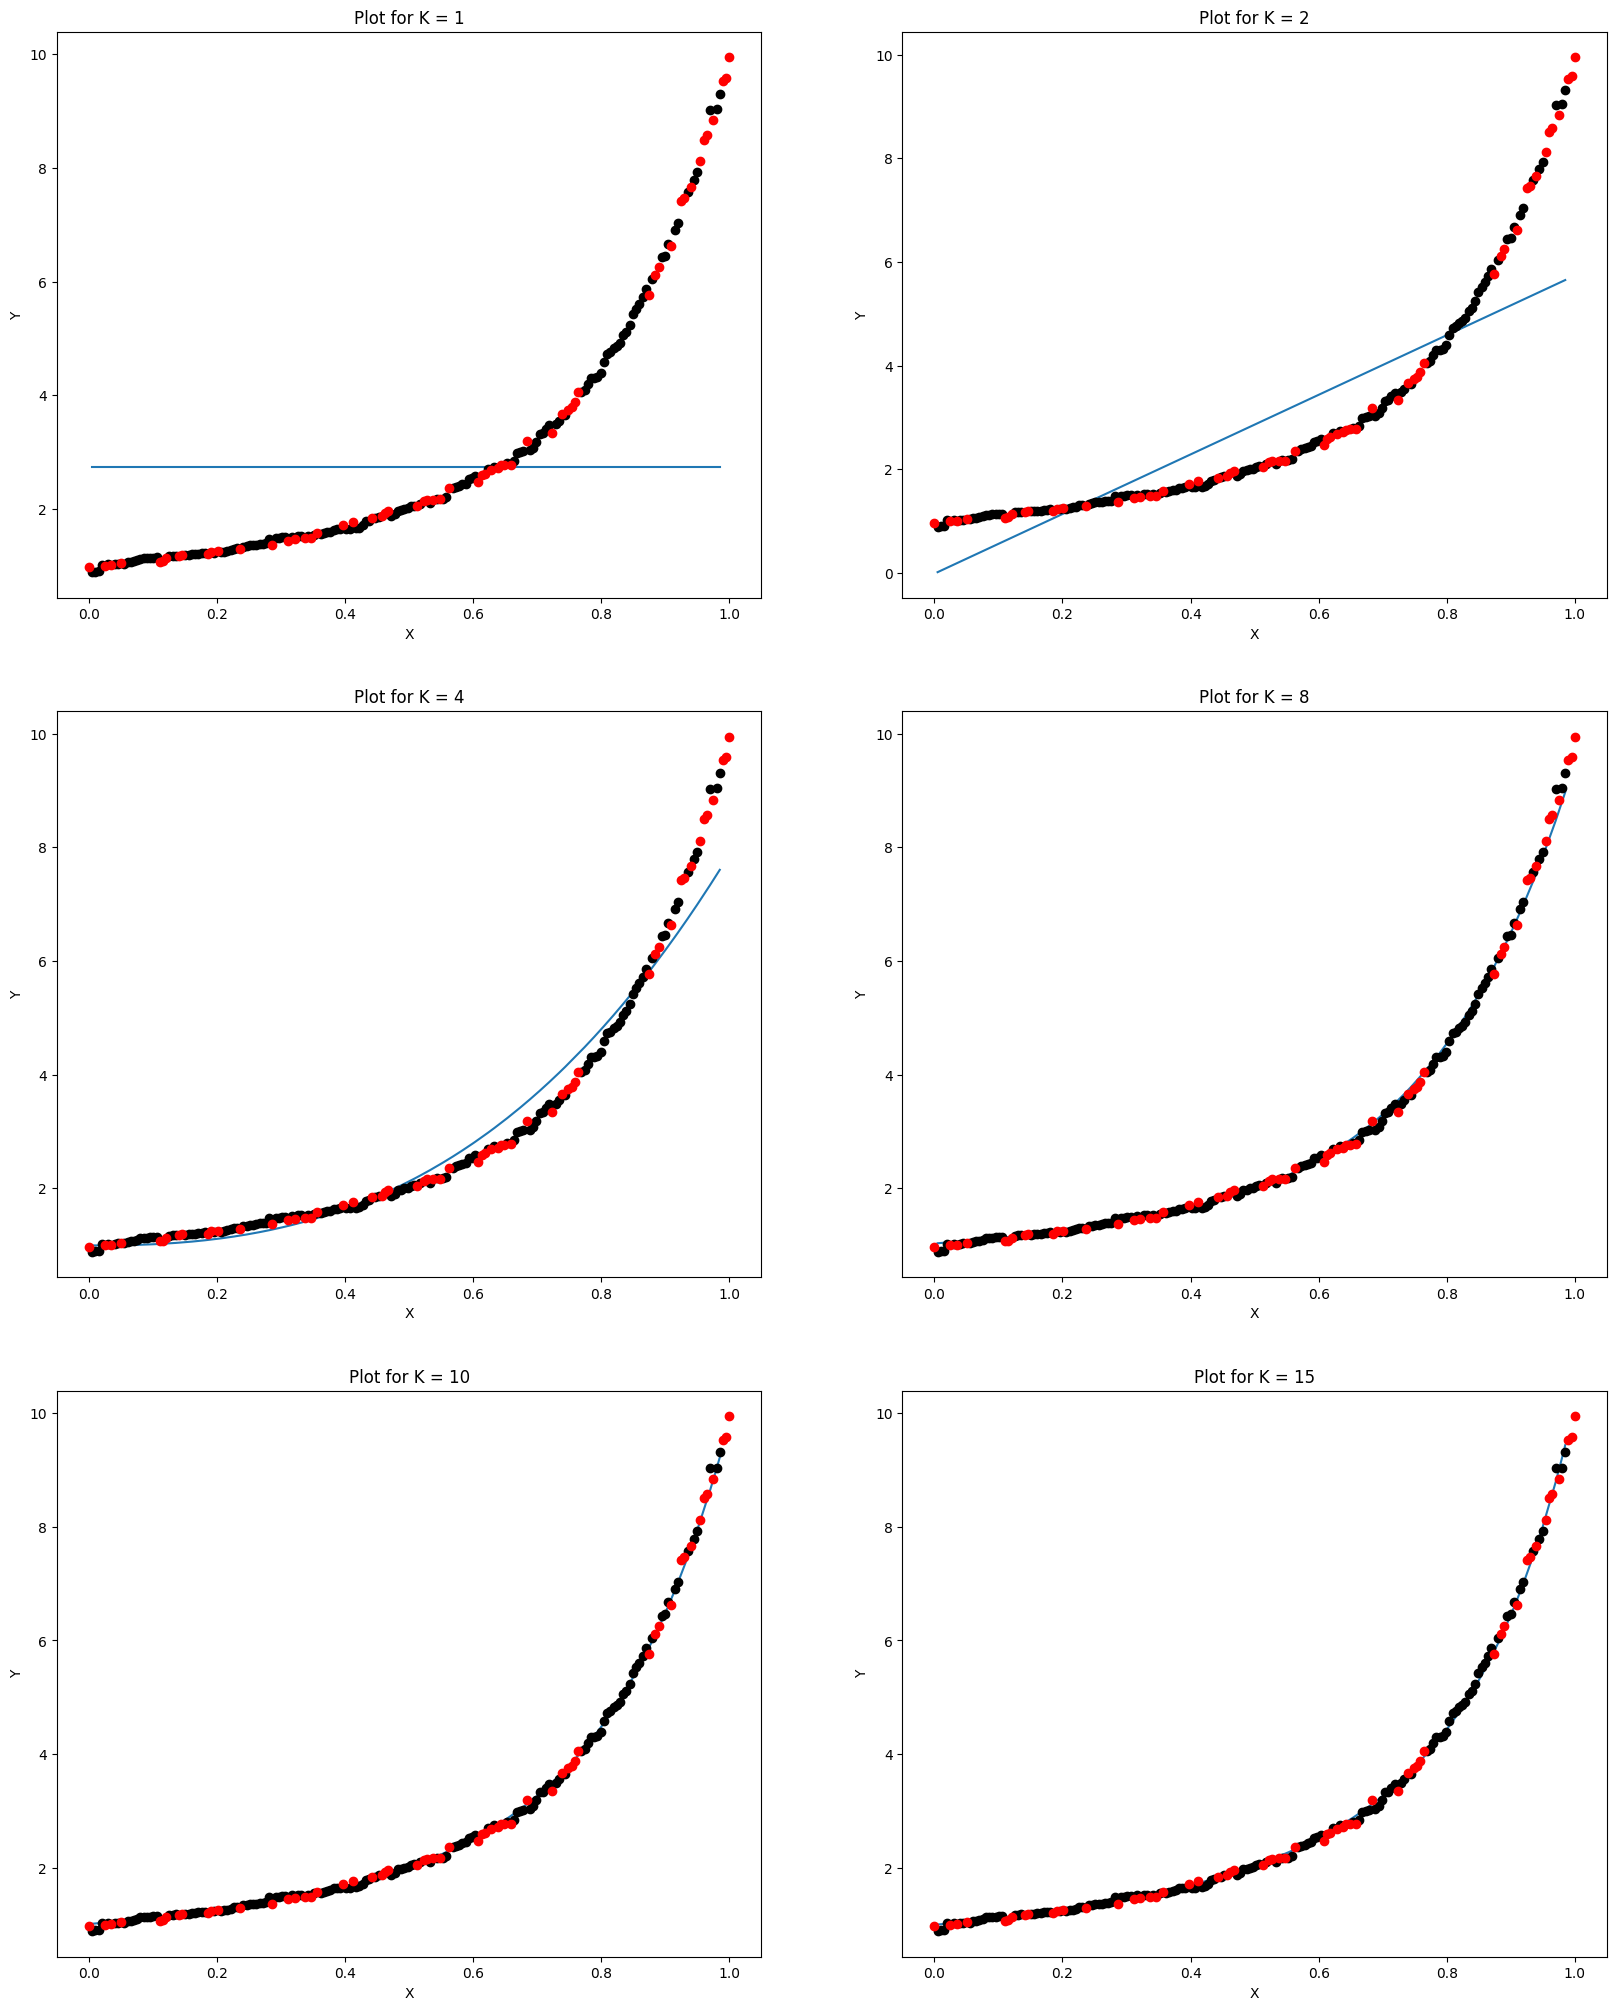

In [27]:
cnt = 0
MAP_NE_train_error = []
MAP_NE_test_error = []
plt.figure(figsize=(20,25))
lmbda = 0.7
val = [1,2,4,8,10,15]
for i in val:
    cnt += 1
    K = i
    theta_zero = np.zeros((K ,1))
    theta_comp = MAP_NE(X_train,Y_train,K,lmbda)
    y_pred_train = vand(X_train,K)@ theta_comp
    MAP_NE_train_error.append(abs_avg_error(X_train,theta_comp,Y_train))
    MAP_NE_test_error.append(abs_avg_error(X_test,theta_comp,Y_test))
    plt.subplot(3,2,cnt)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.plot(sorted(X_train),sorted(y_pred_train))
    plt.plot(sorted(X_train),sorted(Y_train),"ko")
    plt.plot(sorted(X_test),sorted(Y_test),"o",color="red")
    plt.title(f"Plot for K = {i}")
plt.show()

### -Error plot for different K

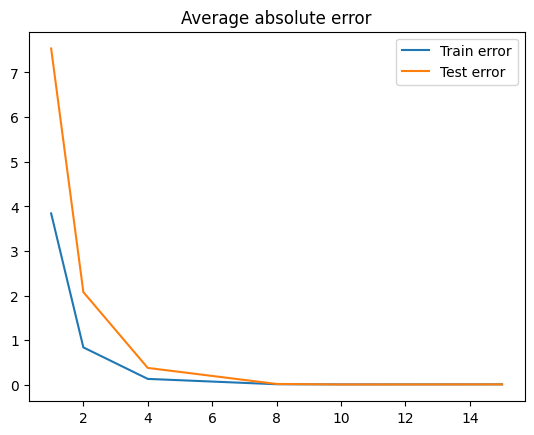

In [28]:
plt.plot(val,MAP_NE_train_error,label="Train error")
plt.plot(val,MAP_NE_test_error,label="Test error")
plt.title("Average absolute error")
plt.legend()
plt.show()

### -Train and Test datapoints plot and learnt model plot for different lambda(regularization factor)

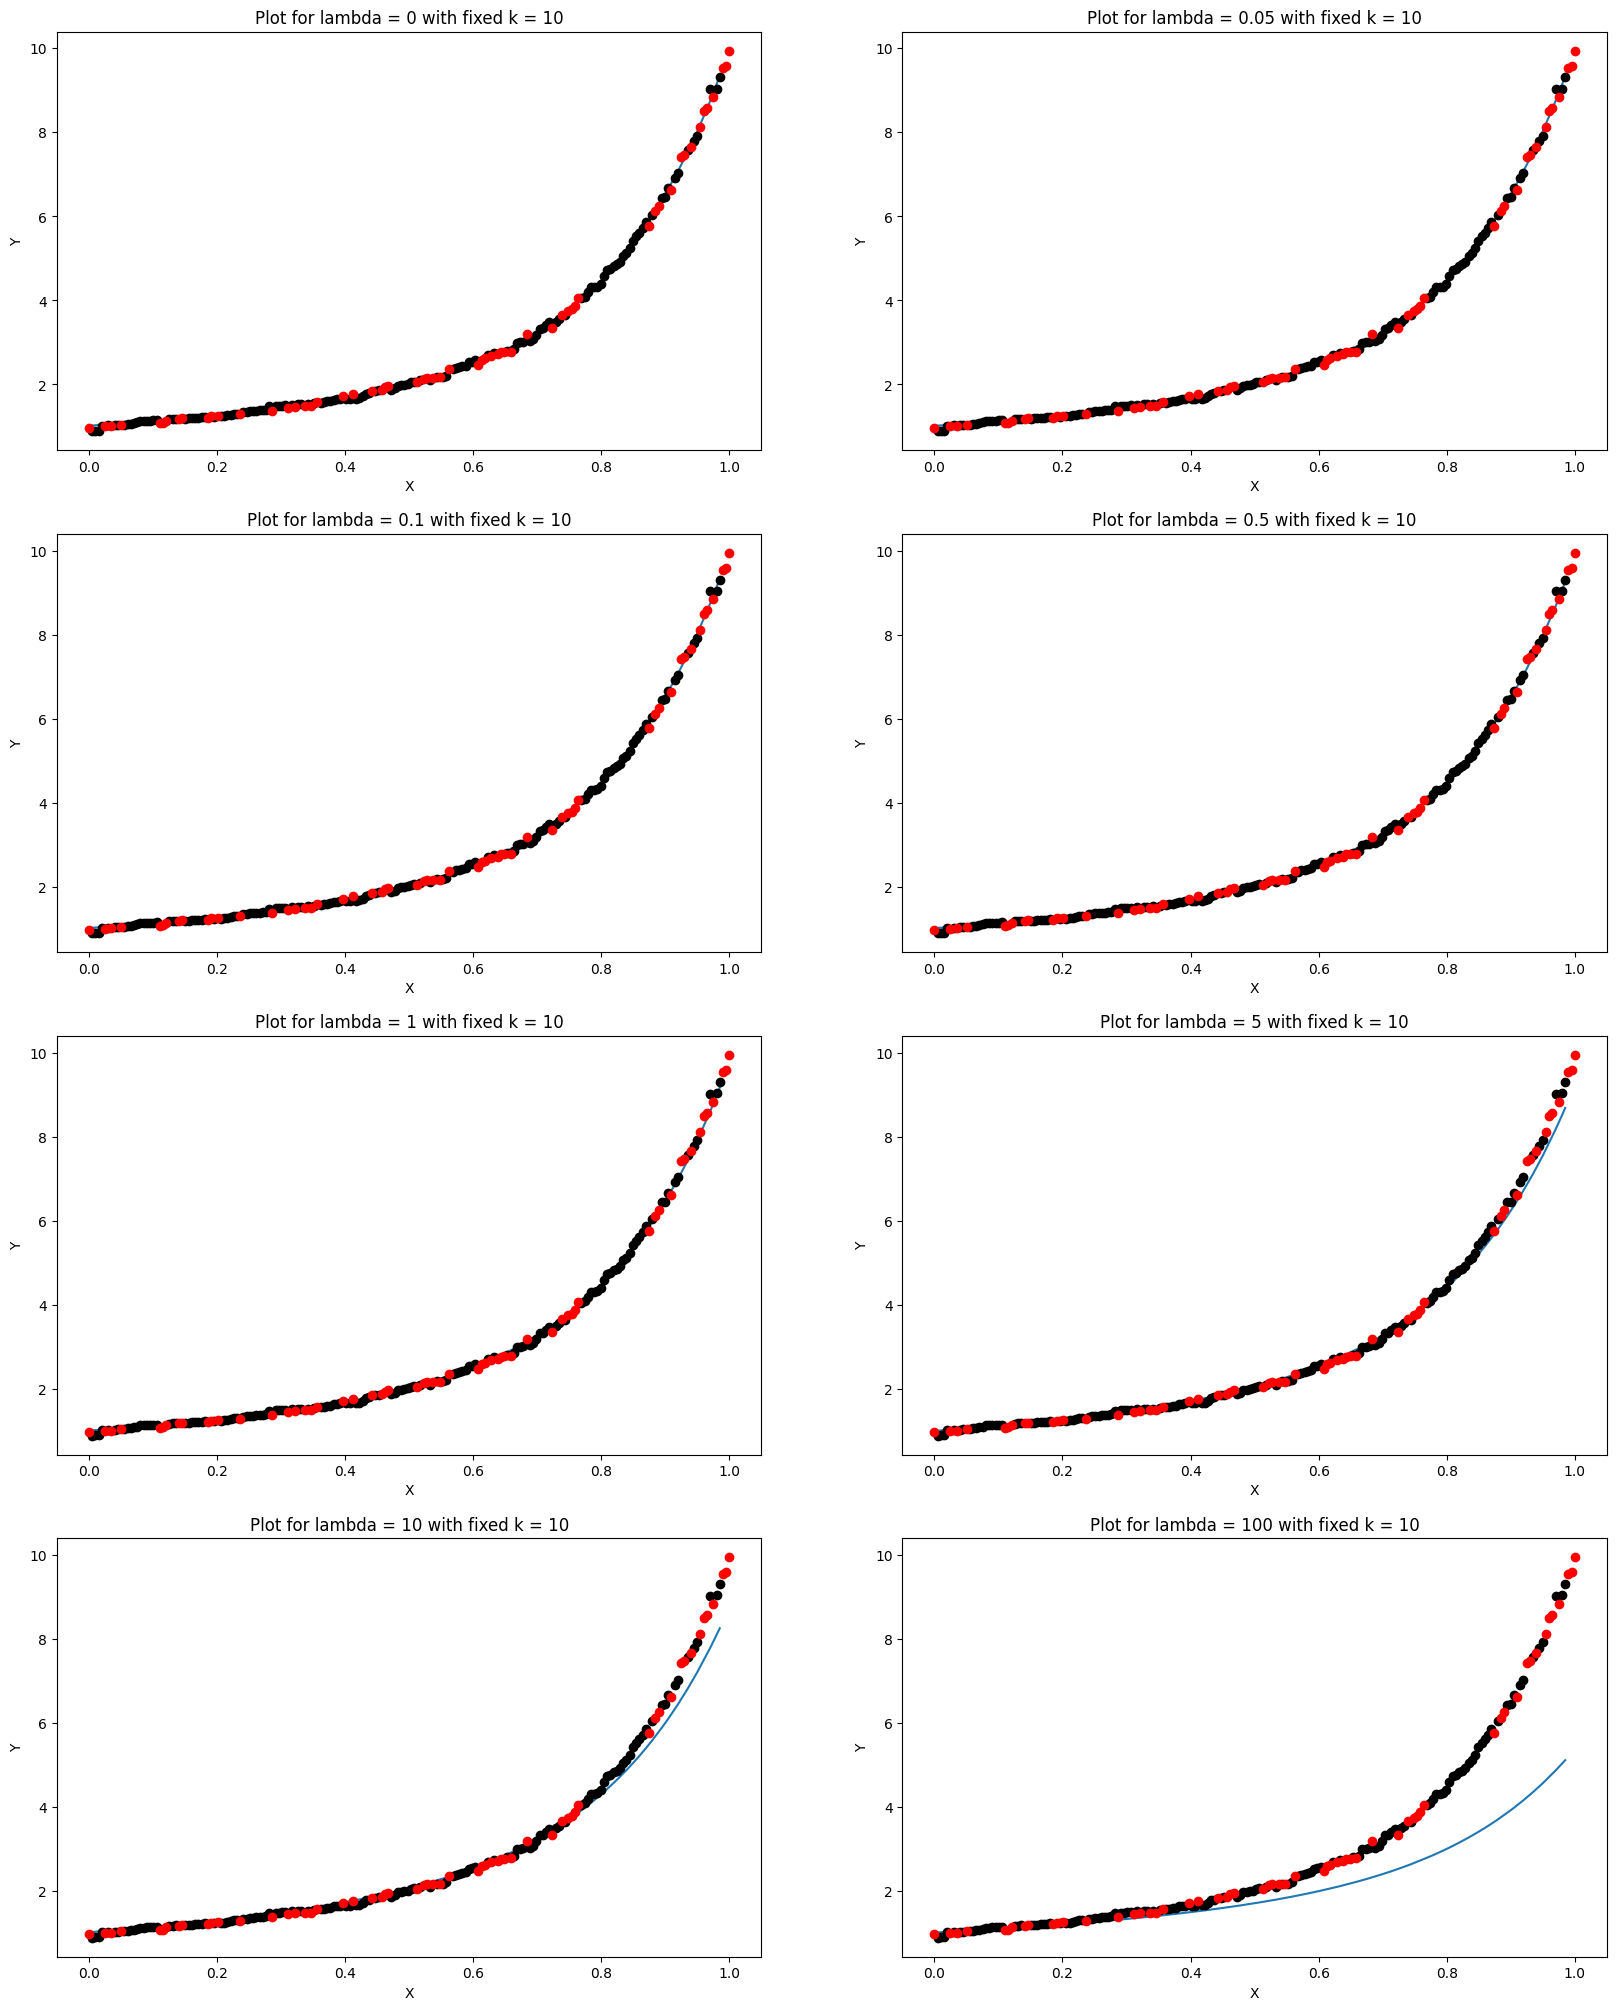

In [29]:
cnt = 0
MAP_NE_train_error = []
MAP_NE_test_error = []
plt.figure(figsize=(20,25))
val = [0,0.05,0.1,0.5,1,5,10,100]
for i in val:
    cnt += 1
    K = 10
    lmbda = i
    theta_zero = np.zeros((K ,1))
    theta_comp = MAP_NE(X_train,Y_train,K,lmbda)
    y_pred_train = vand(X_train,K)@ theta_comp
    MAP_NE_train_error.append(abs_avg_error(X_train,theta_comp,Y_train))
    MAP_NE_test_error.append(abs_avg_error(X_test,theta_comp,Y_test))
    plt.subplot(4,2,cnt)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.plot(sorted(X_train),sorted(y_pred_train))
    plt.plot(sorted(X_train),sorted(Y_train),"ko")
    plt.plot(sorted(X_test),sorted(Y_test),"o",color="red")
    plt.title(f"Plot for lambda = {i} with fixed k = {K}")
plt.show()

### -Error plot for different lambda

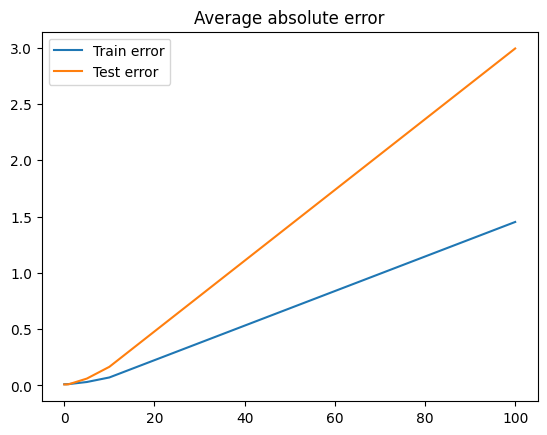

In [30]:
plt.plot(val,MAP_NE_train_error,label="Train error")
plt.plot(val,MAP_NE_test_error,label="Test error")
plt.title("Average absolute error")
plt.legend()
plt.show()

### Comparisons between MLE and MAP

### - SGD -  Test dataset error for K  way greater than the correct degree of the polynomial 

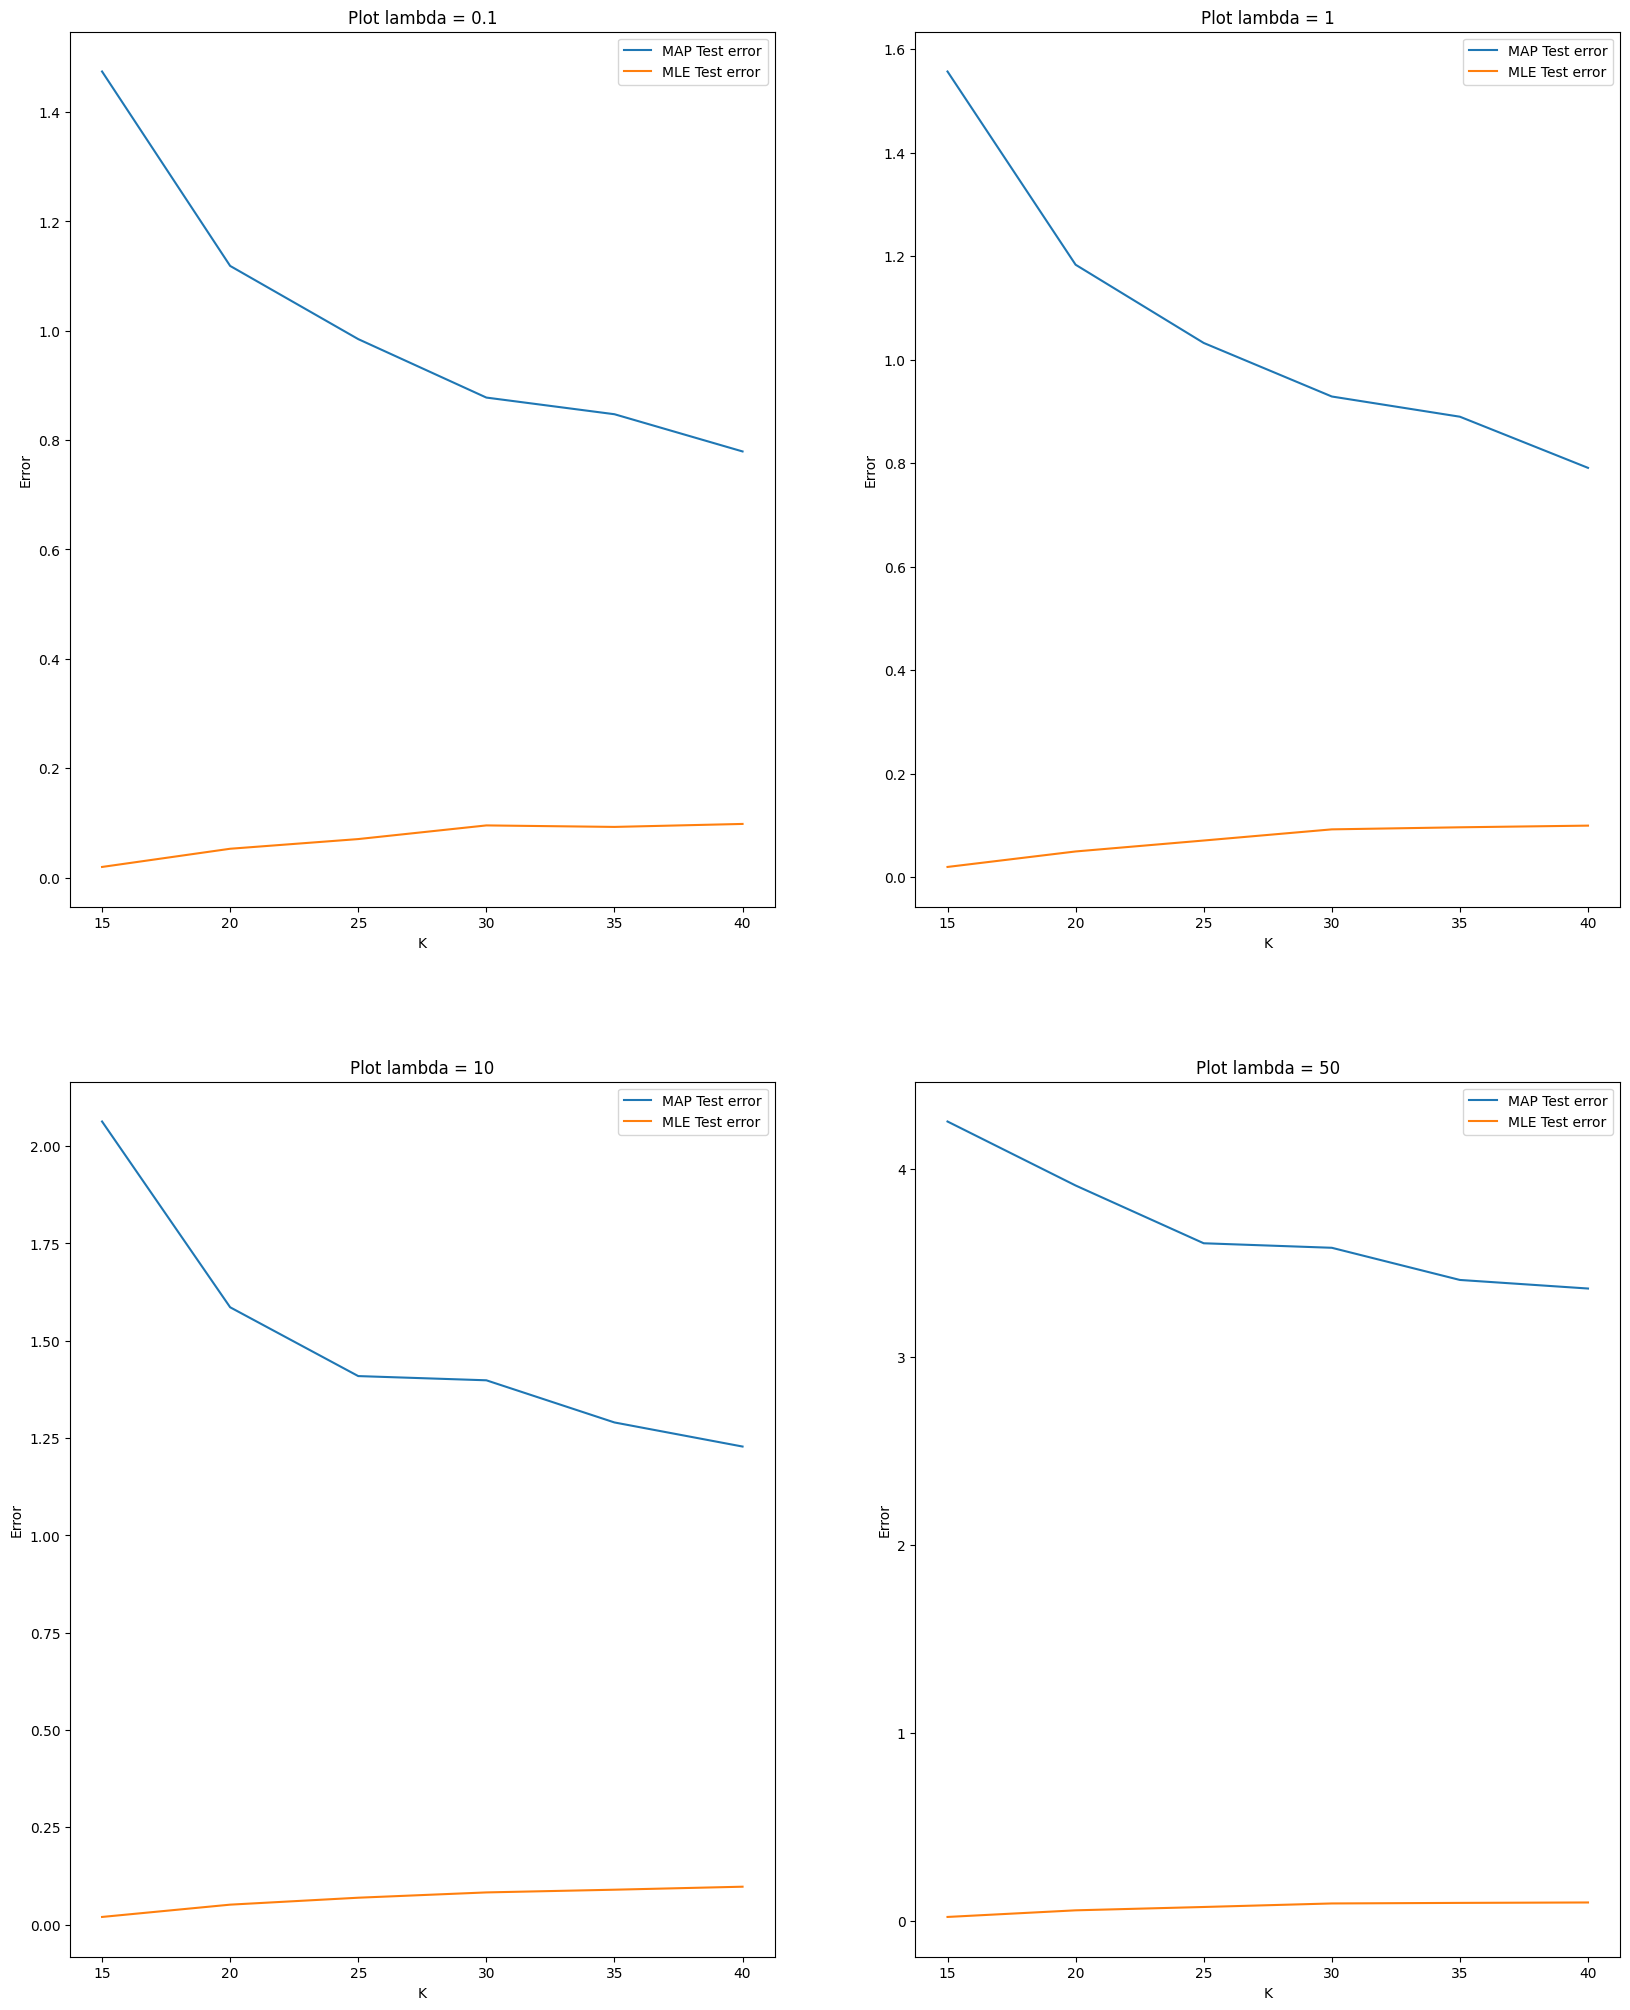

In [31]:

cnt = 0
plt.figure(figsize=(20,25))
val = [0.1,1,10,50]
k_values = [15,20,25,30,35,40]
for i in val:
    MLE_SGD_test_error = []
    MAP_SGD_test_error = []
    for K in k_values:
        lmbda = i
        theta_zero = np.zeros((K ,1))
        theta_comp1 = SGD(grad_f, theta_zero, lmbda, (X_train,Y_train), 50, 100, 1e-4)
        theta_comp2 = SGD(grad_MAP, theta_zero, lmbda, (X_train,Y_train), 50, 100, 1e-4)
        MLE_SGD_test_error.append(abs_avg_error(X_test,theta_comp1,Y_test))
        MAP_SGD_test_error.append(abs_avg_error(X_test,theta_comp2,Y_test))
    cnt += 1
    plt.subplot(2,2,cnt)
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.title(f"Plot lambda = {lmbda}")
    plt.plot(k_values,MAP_SGD_test_error,label="MAP Test error")
    plt.plot(k_values,MLE_SGD_test_error,label="MLE Test error")
    plt.legend()
    
plt.show()

### - GD -  Test dataset error for K  way greater than the correct degree of the polynomial 

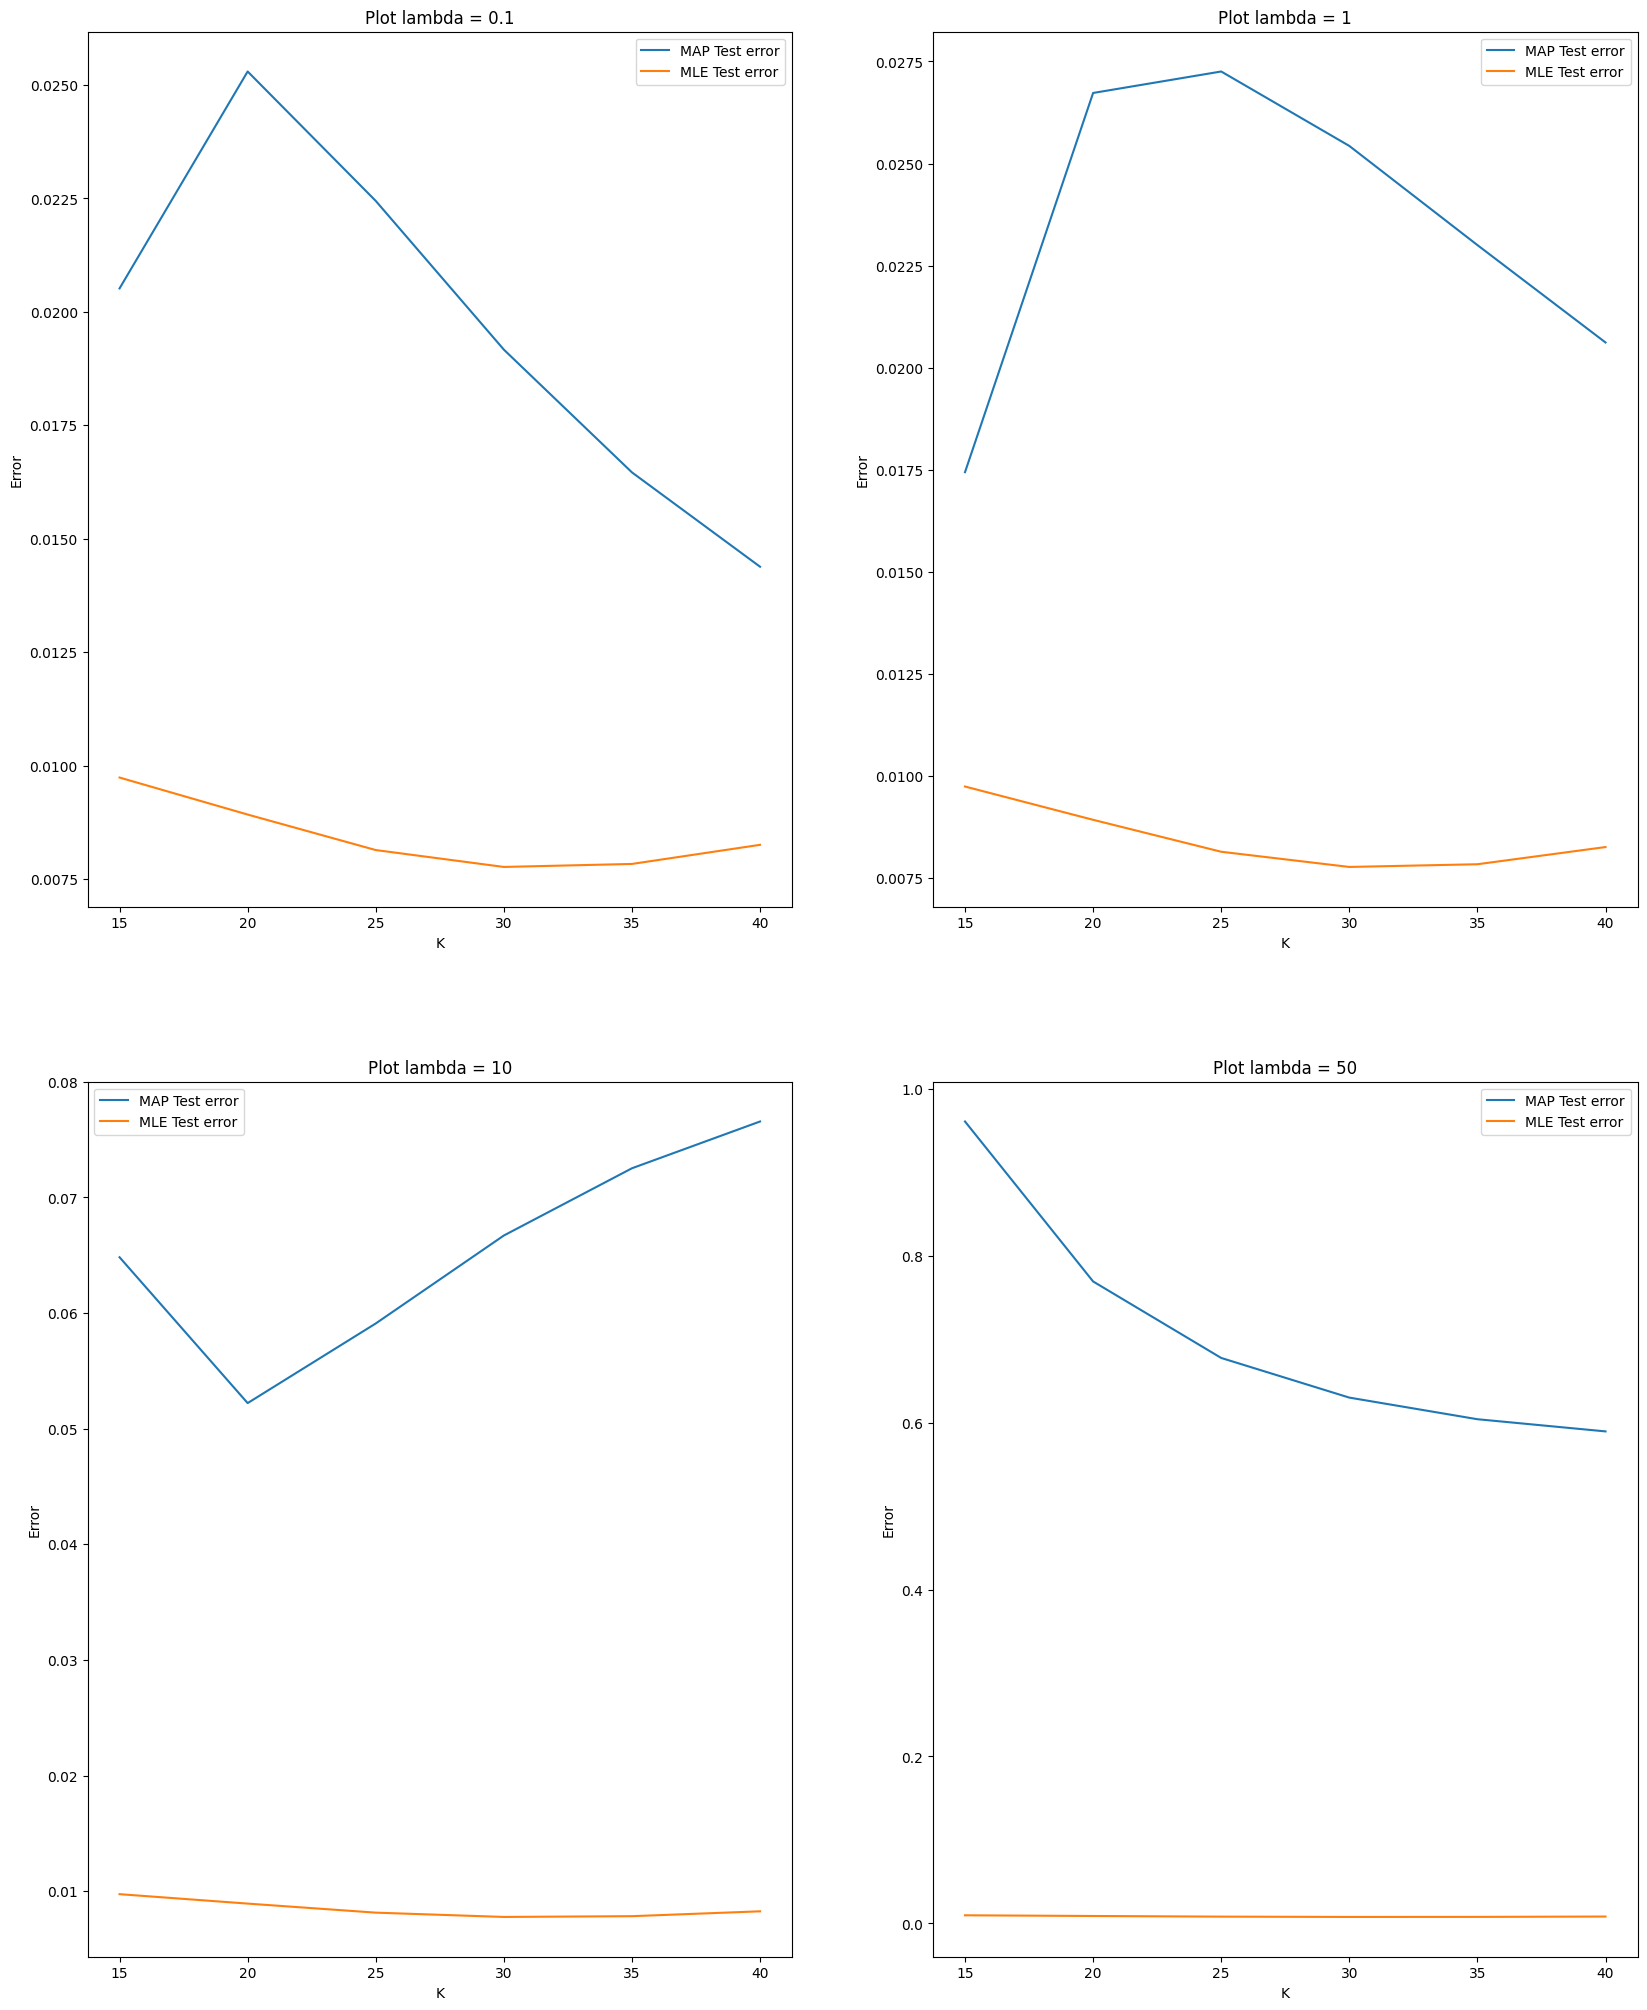

In [32]:
cnt = 0
plt.figure(figsize=(20,25))
val = [0.1,1,10,50]
k_values = [15,20,25,30,35,40]
for i in val:
    MLE_GD_test_error = []
    MAP_GD_test_error = []
    for K in k_values:
        lmbda = i
        theta_zero = np.zeros((K ,1))
        theta_comp1 = GD(grad_f, theta_zero, lmbda, (X_train,Y_train),  100000, 1e-5, 1e-5, 0.00001)
        theta_comp2 = GD(grad_MAP, theta_zero, lmbda, (X_train,Y_train),  100000, 1e-5, 1e-5, 0.00001)
        MLE_GD_test_error.append(abs_avg_error(X_test,theta_comp1,Y_test))
        MAP_GD_test_error.append(abs_avg_error(X_test,theta_comp2,Y_test))
    cnt += 1
    plt.subplot(2,2,cnt)
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.title(f"Plot lambda = {lmbda}")
    plt.plot(k_values,MAP_GD_test_error,label="MAP Test error")
    plt.plot(k_values,MLE_GD_test_error,label="MLE Test error")
    plt.legend()
    
plt.show()

### - NE -  Test dataset error for K  way greater than the correct degree of the polynomial 

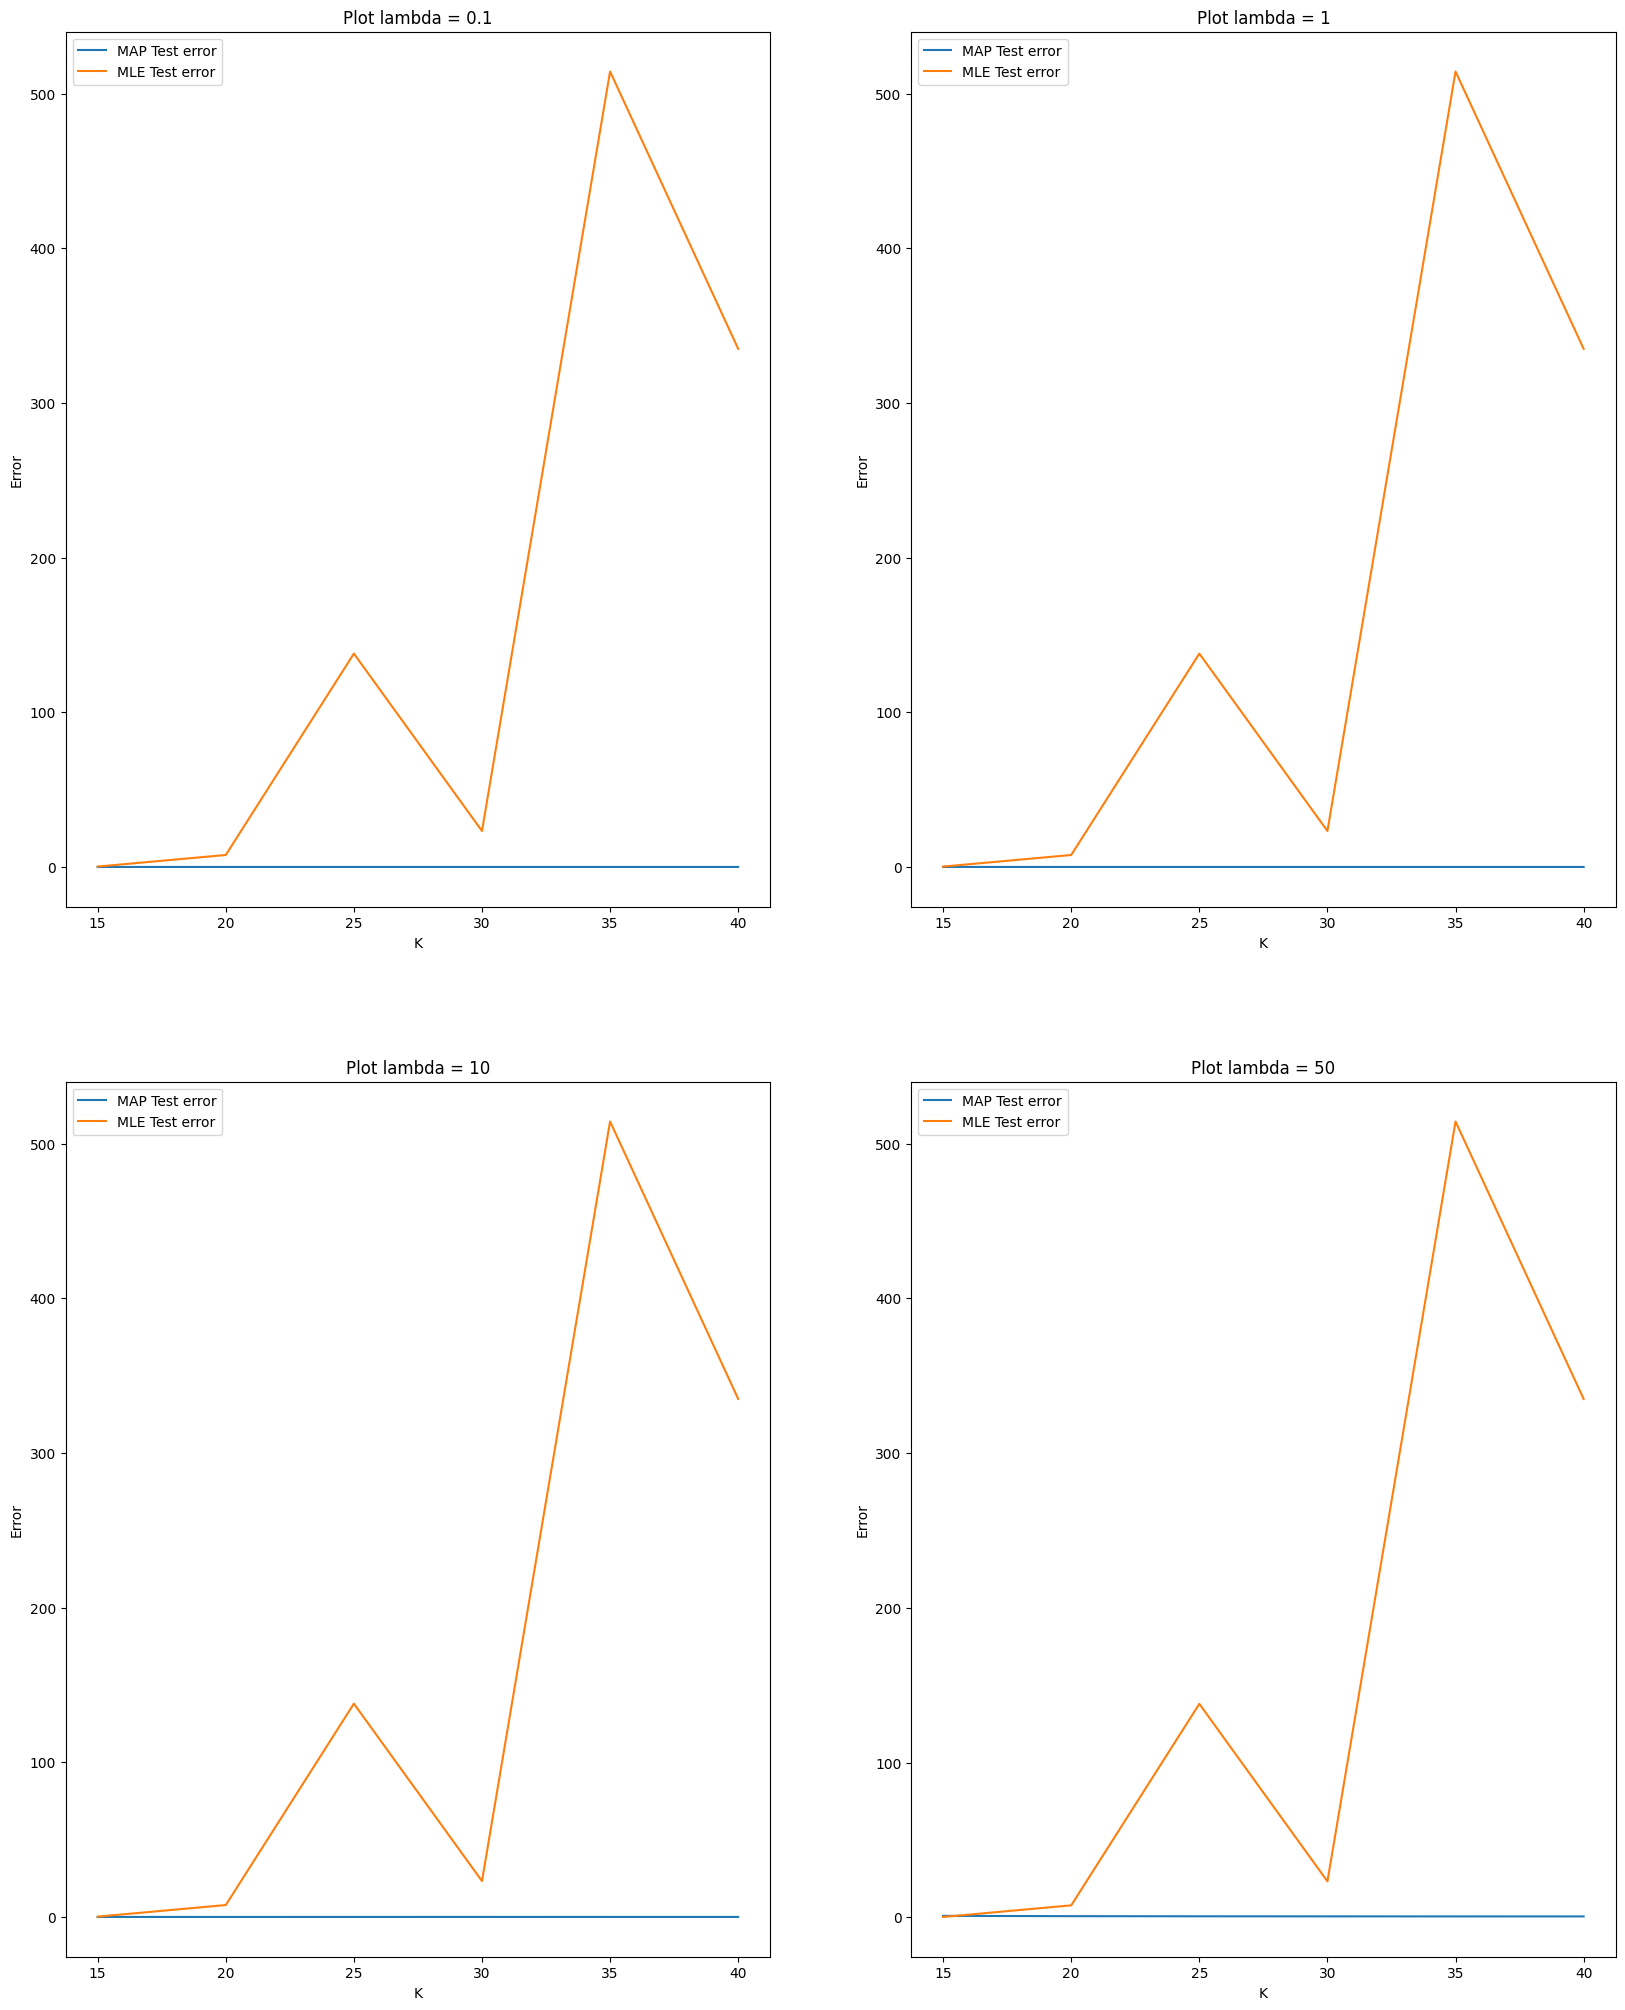

In [33]:
cnt = 0
plt.figure(figsize=(20,25))
val = [0.1,1,10,50]
k_values = [15,20,25,30,35,40]
for i in val:
    MLE_NE_test_error = []
    MAP_NE_test_error = []
    for K in k_values:
        lmbda = i
        theta_zero = np.zeros((K ,1))
        theta_comp1 = NE(X_train,Y_train,K)
        theta_comp2 = MAP_NE(X_train,Y_train,K,lmbda)
        MLE_NE_test_error.append(abs_avg_error(X_test,theta_comp1,Y_test))
        MAP_NE_test_error.append(abs_avg_error(X_test,theta_comp2,Y_test))
    cnt += 1
    plt.subplot(2,2,cnt)
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.title(f"Plot lambda = {lmbda}")
    plt.plot(k_values,MAP_NE_test_error,label="MAP Test error")
    plt.plot(k_values,MLE_NE_test_error,label="MLE Test error")
    plt.legend()
    
plt.show()

### -SGD- Relative error of theta between the two models for different values of K and lambda

In [34]:
def err_rel(theta,theta_true):
    t_true = np.zeros_like(theta)
    t_true[:len(theta_true)] = theta_true
    return np.linalg.norm(theta-t_true,2)/np.linalg.norm(t_true,2)

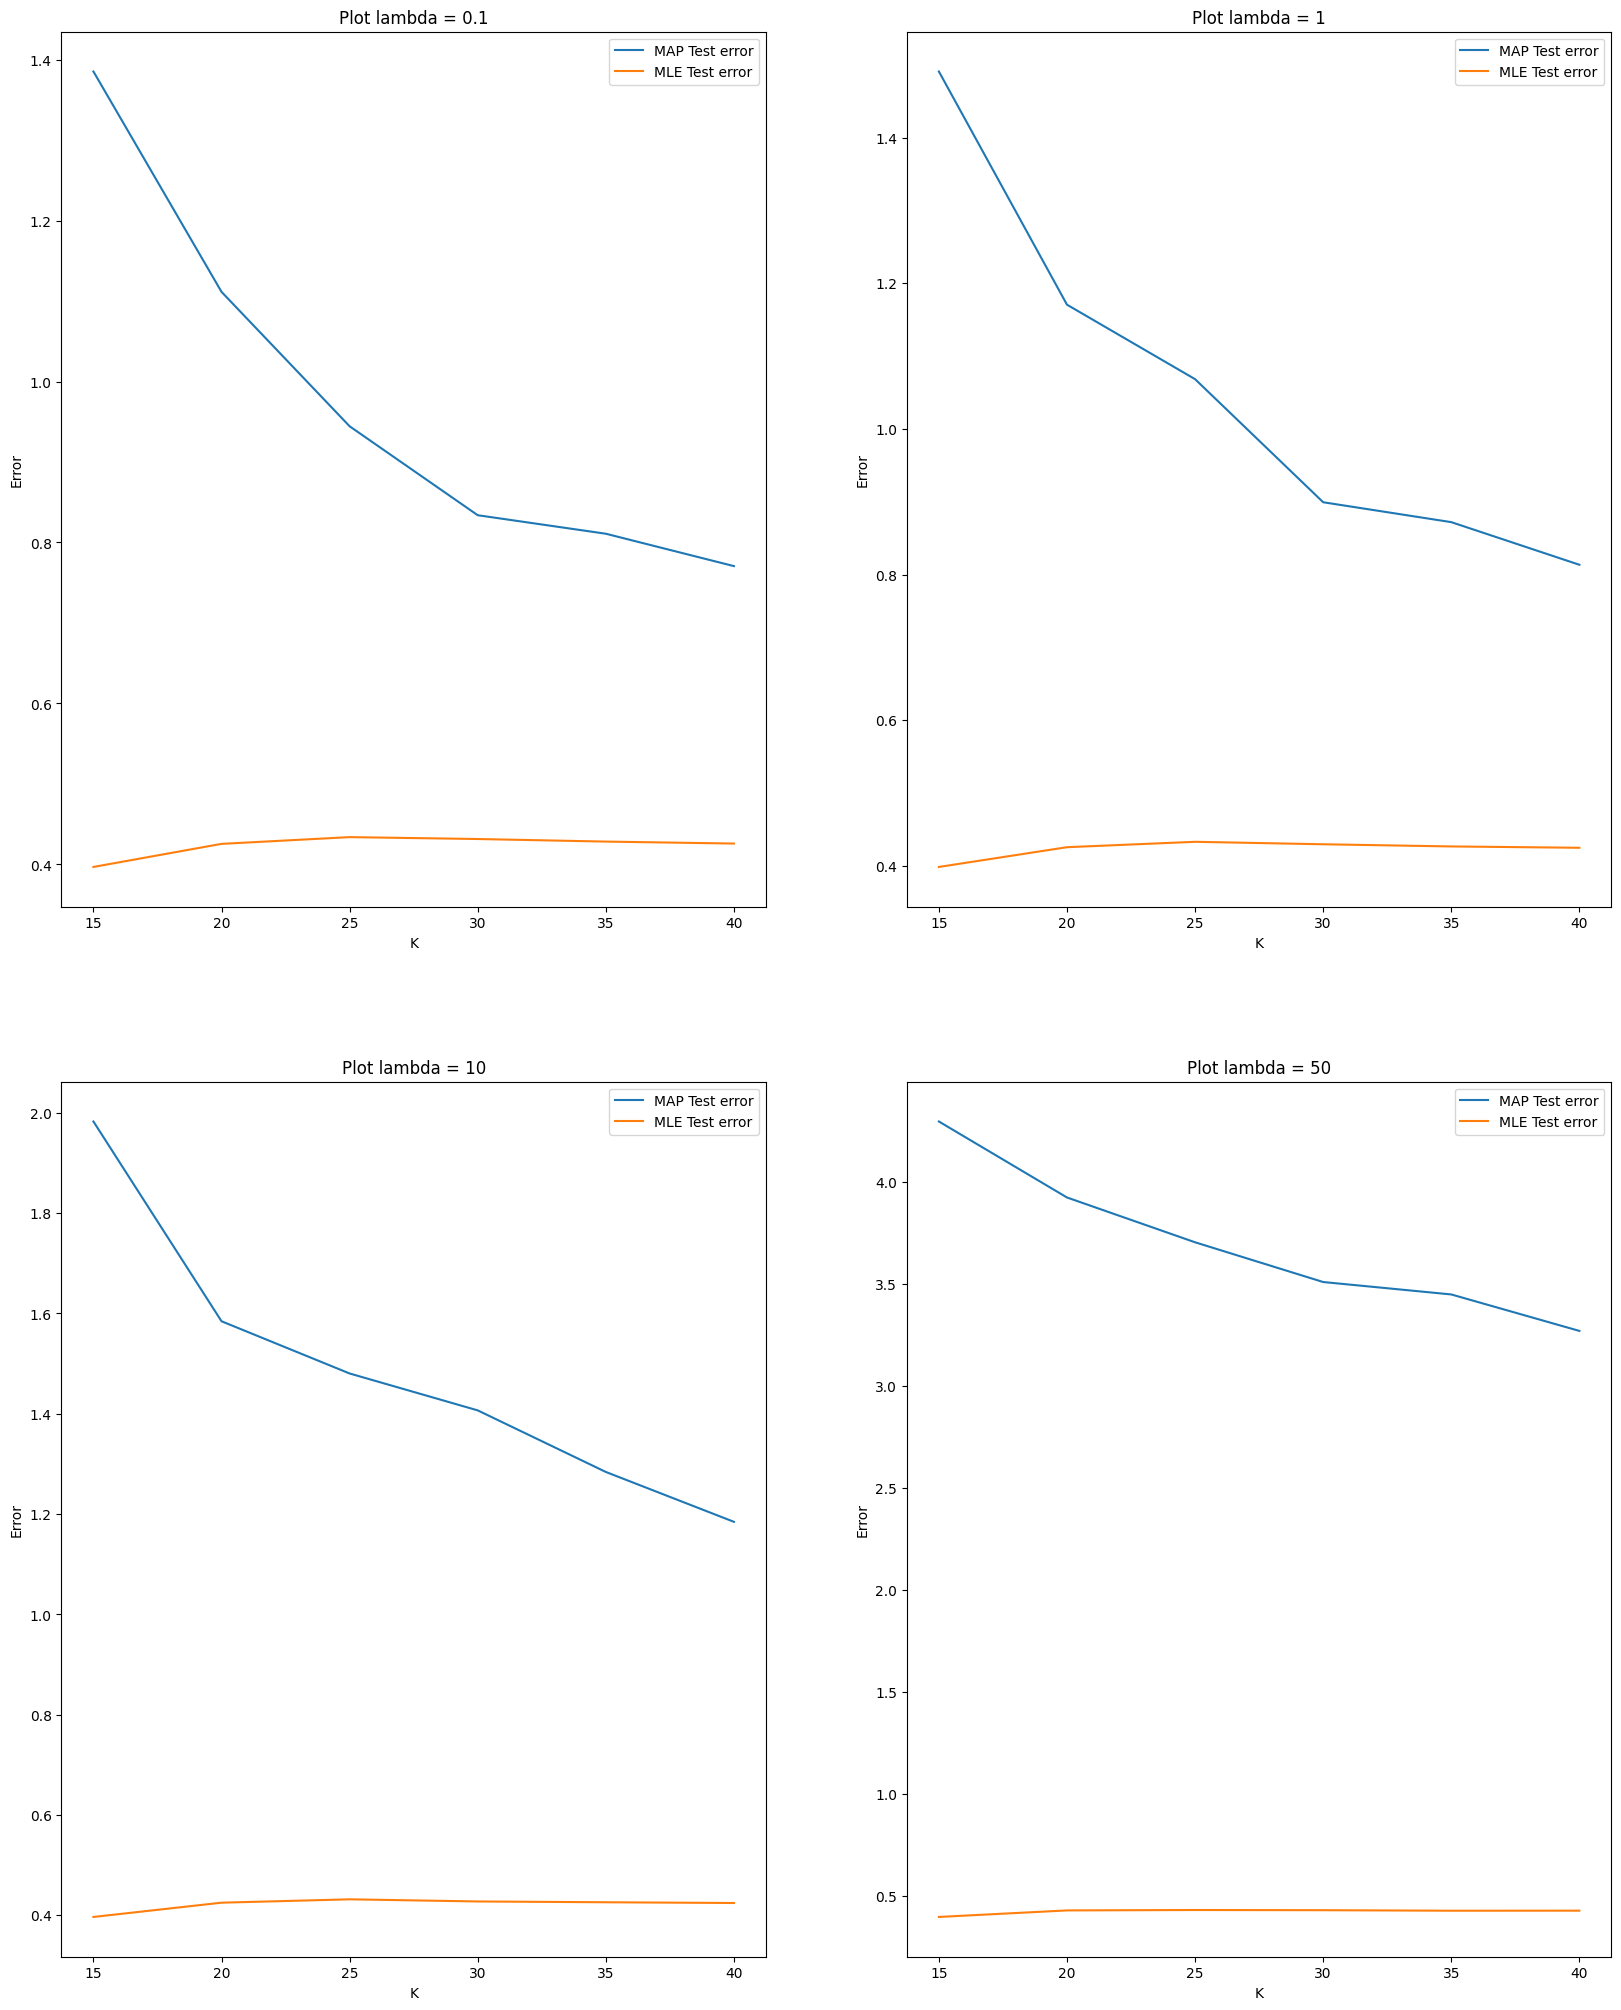

In [35]:
cnt = 0
plt.figure(figsize=(20,25))
val = [0.1,1,10,50]
k_values = [15,20,25,30,35,40]
for i in val:
    MLE_SGD_test_error = []
    MAP_SGD_test_error = []
    for K in k_values:
        lmbda = i
        theta_zero = np.zeros((K ,1))
        theta_comp1 = SGD(grad_f, theta_zero, lmbda, (X_train,Y_train), 50, 100, 1e-4)
        theta_comp2 = SGD(grad_MAP, theta_zero, lmbda, (X_train,Y_train), 50, 100, 1e-4)
        MLE_SGD_test_error.append(err_rel(theta_comp1,theta_true))
        MAP_SGD_test_error.append(abs_avg_error(X_test,theta_comp2,Y_test))
    cnt += 1
    plt.subplot(2,2,cnt)
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.title(f"Plot lambda = {lmbda}")
    plt.plot(k_values,MAP_SGD_test_error,label="MAP Test error")
    plt.plot(k_values,MLE_SGD_test_error,label="MLE Test error")
    plt.legend()
    
plt.show()

### -GD- Relative error of theta between the two models for different values of K and lambda

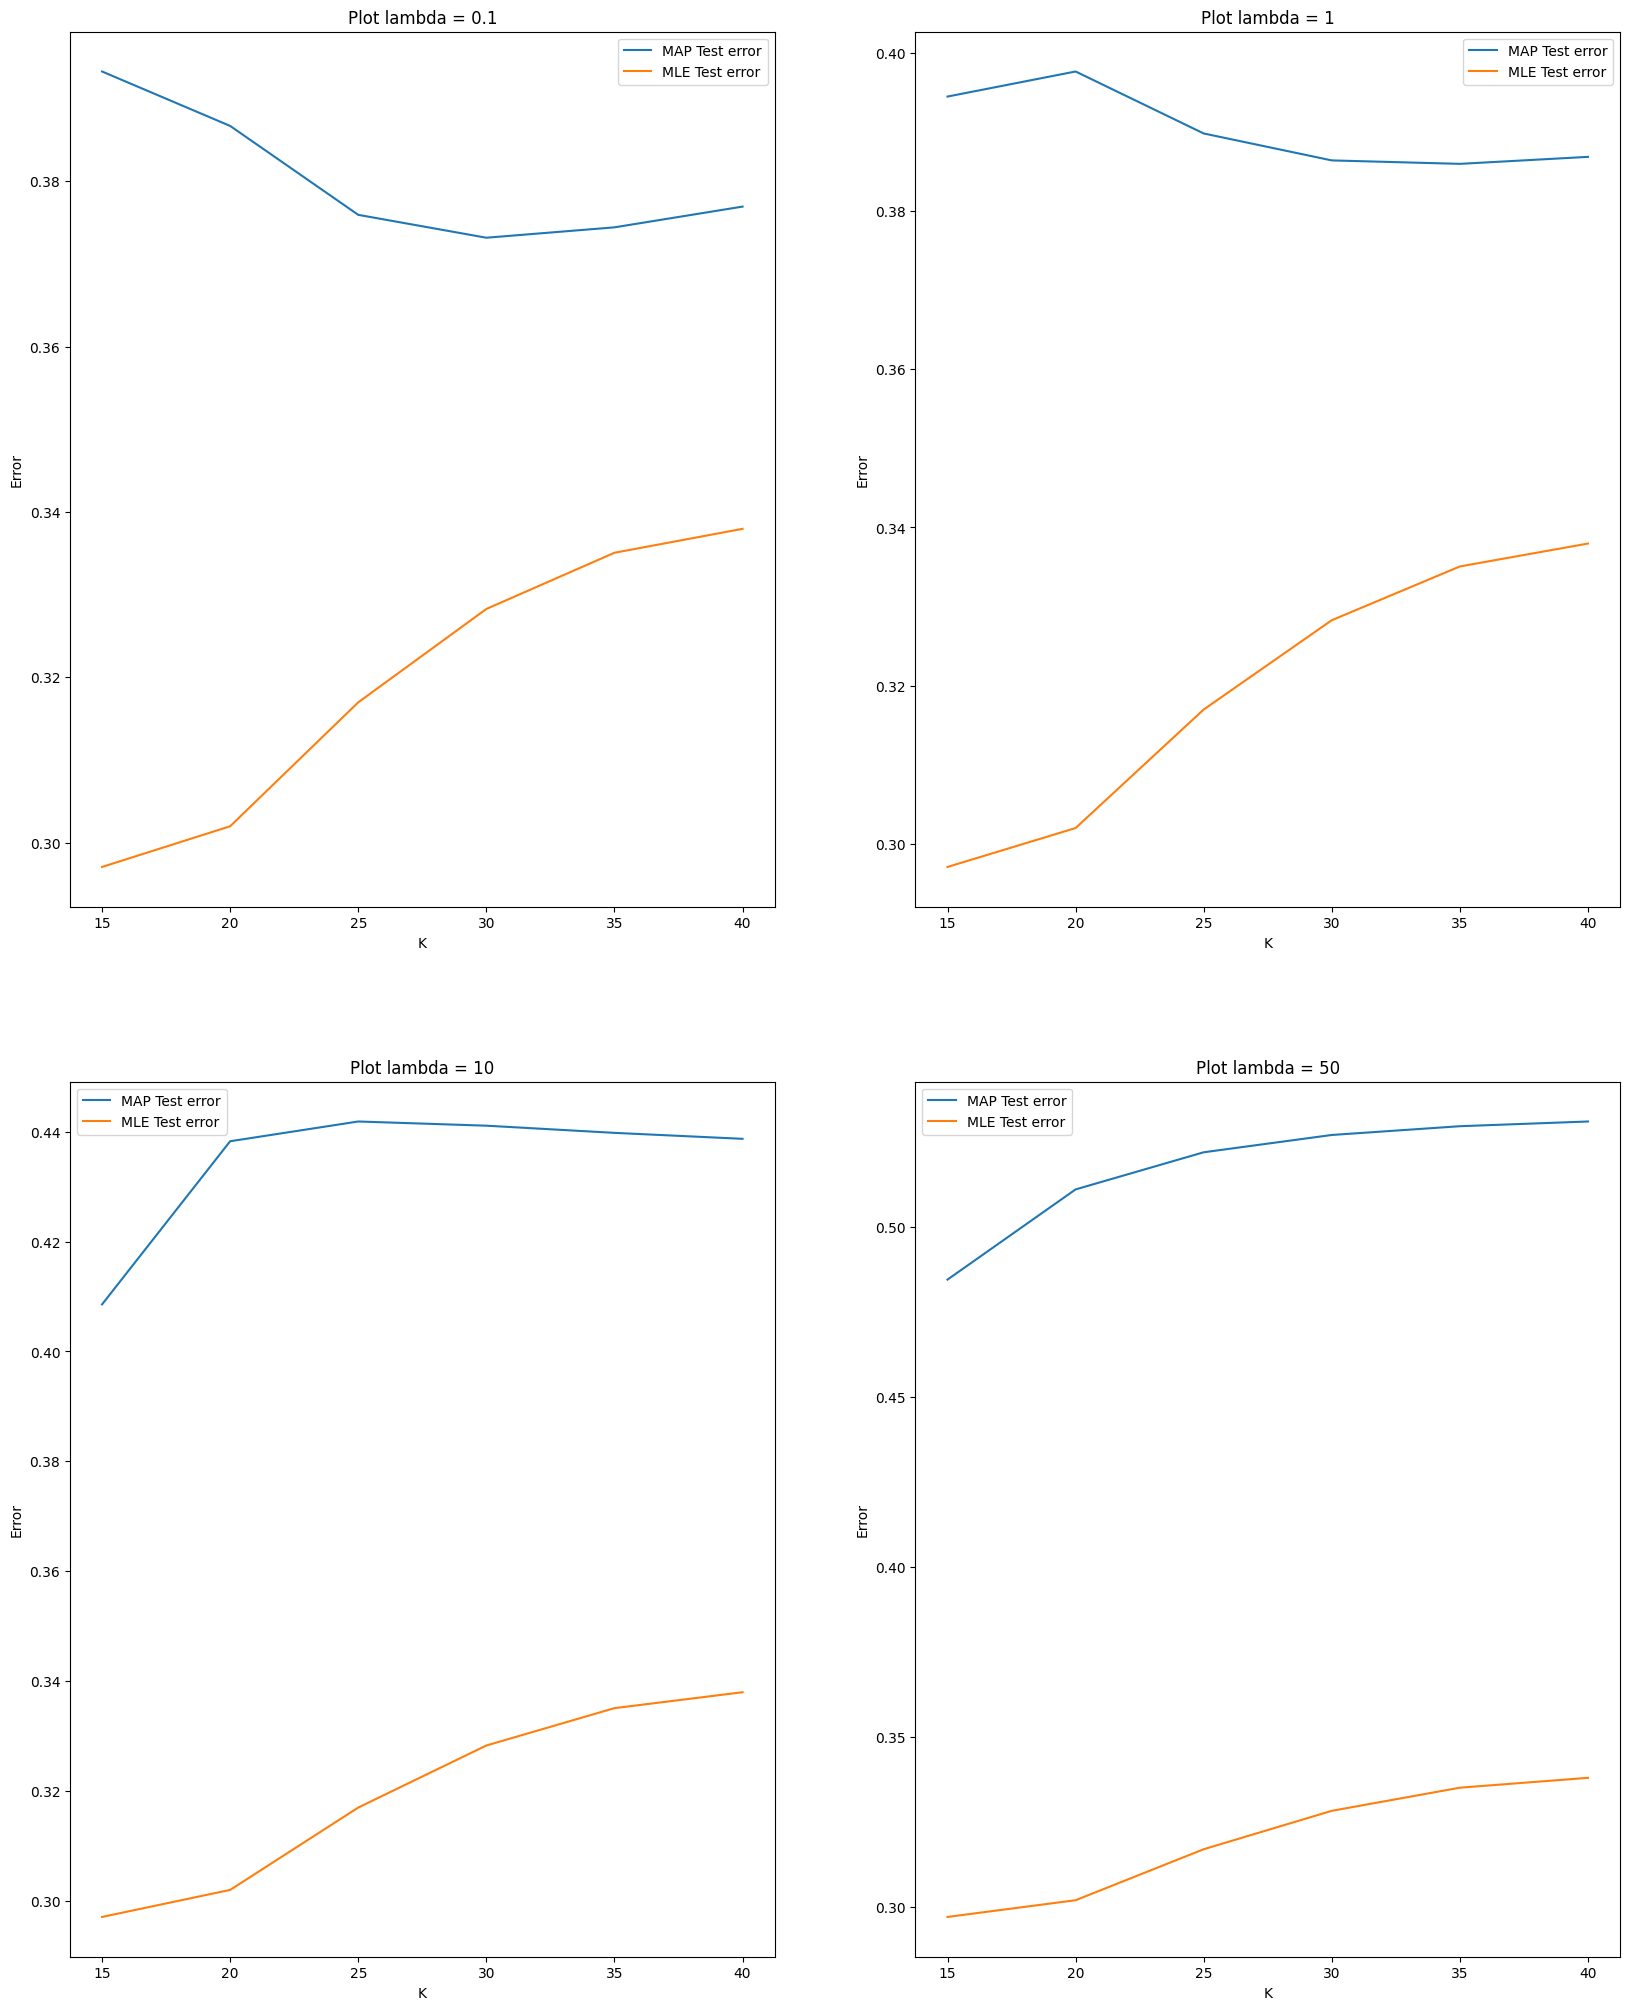

In [36]:
cnt = 0
plt.figure(figsize=(20,25))
val = [0.1,1,10,50]
k_values = [15,20,25,30,35,40]
for i in val:
    MLE_GD_test_error = []
    MAP_GD_test_error = []
    for K in k_values:
        lmbda = i
        theta_zero = np.zeros((K ,1))
        theta_comp1 = GD(grad_f, theta_zero, lmbda, (X_train,Y_train),  100000, 1e-5, 1e-5, 0.00001)
        theta_comp2 = GD(grad_MAP, theta_zero, lmbda, (X_train,Y_train),  100000, 1e-5, 1e-5, 0.00001)
        MLE_GD_test_error.append(err_rel(theta_comp1,theta_true))
        MAP_GD_test_error.append(err_rel(theta_comp2,theta_true))
    cnt += 1
    plt.subplot(2,2,cnt)
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.title(f"Plot lambda = {lmbda}")
    plt.plot(k_values,MAP_GD_test_error,label="MAP Test error")
    plt.plot(k_values,MLE_GD_test_error,label="MLE Test error")
    plt.legend()
    
plt.show()

### -NE- Relative error of theta between the two models for different values of K and lambda

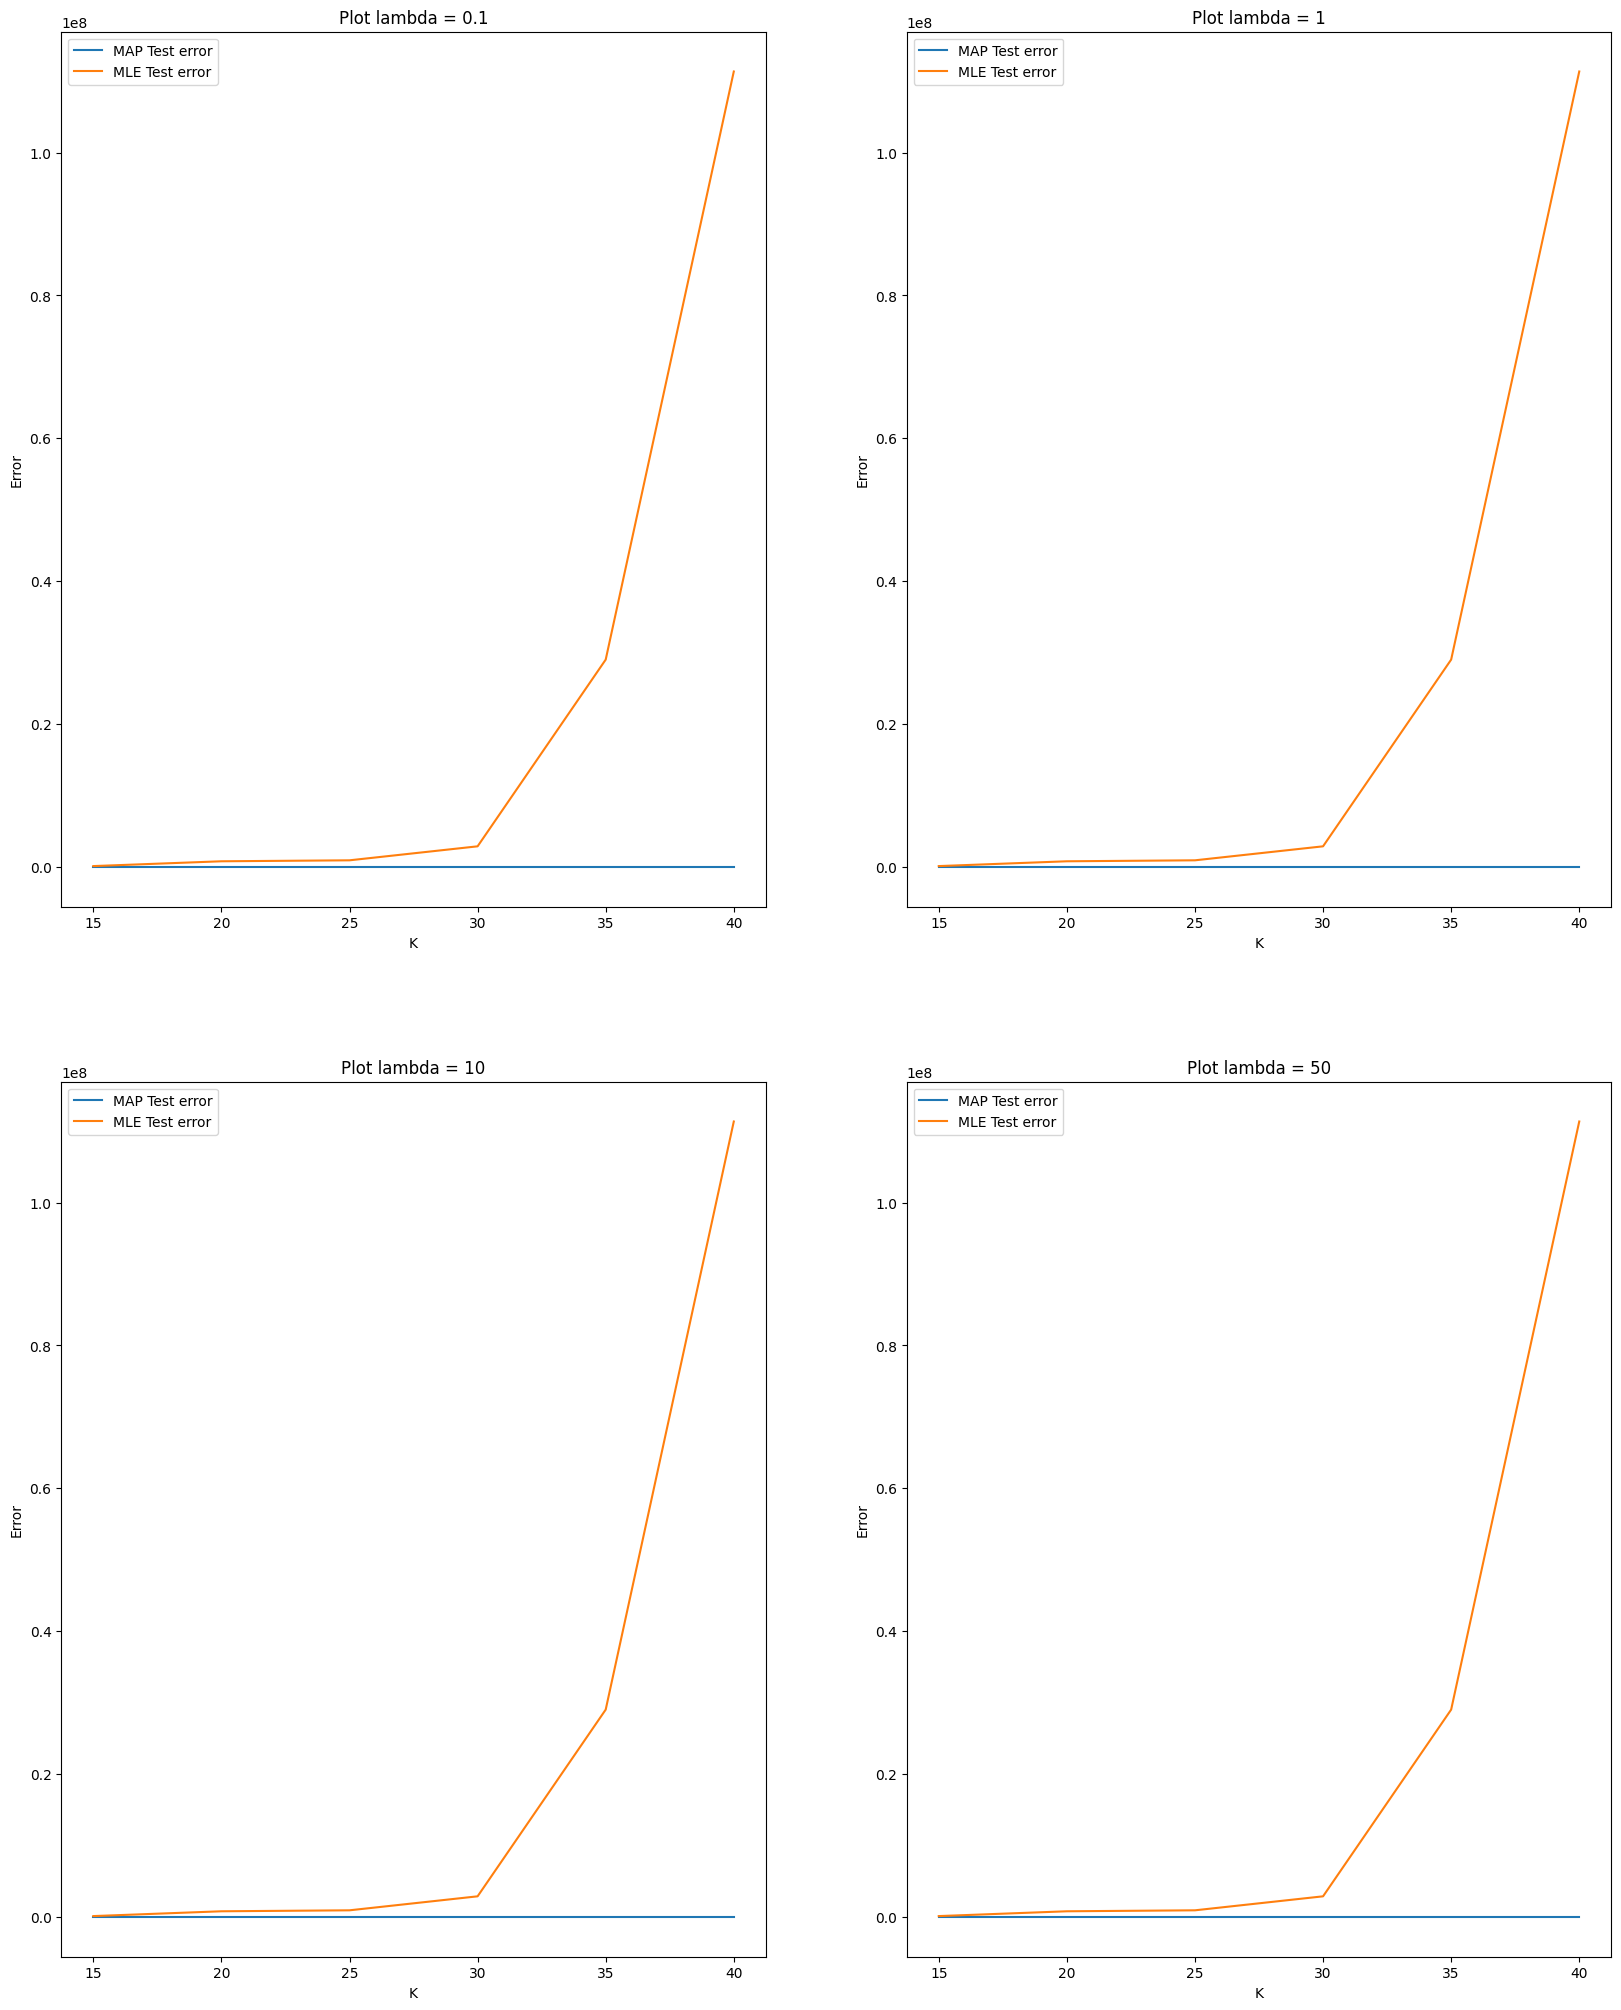

In [37]:
cnt = 0
plt.figure(figsize=(20,25))
val = [0.1,1,10,50]
k_values = [15,20,25,30,35,40]
for i in val:
    MLE_NE_test_error = []
    MAP_NE_test_error = []
    for K in k_values:
        lmbda = i
        theta_zero = np.zeros((K ,1))
        theta_comp1 = NE(X_train,Y_train,K)
        theta_comp2 = MAP_NE(X_train,Y_train,K,lmbda)
        MLE_NE_test_error.append(err_rel(theta_comp1,theta_true))
        MAP_NE_test_error.append(err_rel(theta_comp2,theta_true))
    cnt += 1
    plt.subplot(2,2,cnt)
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.title(f"Plot lambda = {lmbda}")
    plt.plot(k_values,MAP_NE_test_error,label="MAP Test error")
    plt.plot(k_values,MLE_NE_test_error,label="MLE Test error")
    plt.legend()
    
plt.show()